# Bankruptcy Prediction Model for Public Firms

ECON323 003 Final Project

Team Member:
Bryan Hui (53984746)
Roslyn Zheng (14852040)
Elaine Li (50370451)

### Introduction

Our project examines the question, *What is the likelihood that a publicly traded company will go bankrupt?*

Specifically, we will make economic assumptions and employ exploratory analysis to discover relationships between bankruptcy and firm-specific variables. 

The specific model we will use to forecast bankruptcy is logistic regression. We will fit a logistic model on each selected variable and all selected variables combined to see the effect of a single variable on bankruptcies and multiple variables on bankruptcies. 

Given constraints in finding bankrupted firms' data, we used the Bankruptcy data from the Taiwan Economic Journal for 1999–2009. This reasonably extensive dataset contains 220 defaulted firms, so we hope to achieve great prediction results. 

We shall use classification reports and confusion matrices to see the performance of each model. Receiver Operating Characteristic (ROC) curves are used to determine the threshold at which we minimize the number of false positives while maximizing the number of true positives. 

Finally, we will try our models on the Silicon Valley Bank (SVB) data to see if the bankruptcy models can work for U.S. firms.

### Context:

#### Defining Default
Default is the failure to make required interest or principal repayments on a debt, whether that debt is a loan or a security. A company unable to make required loan or coupon payments on its bonds would be in Default. Rating agencies (i.e., Standard and Poor's, Moody's, and Fitch) generally examine a company's financial statements and employ several financial ratios, such as debt ratios and net worth to assets, to create models to compute the probability of Default for individual firms.
- We expect firms with high debt, worsening operations, and lowering equity to be more likely to default.
- The default is a yes-or-no event; the bankrupt variable has a value of 1 if the firm defaulted and 0 otherwise.


#### Taiwan economy 
Taiwan is a top U.S. trade partner and a critical link in global technology and manufacturing supply chains, supporting both the U.S. and China markets. Regarding purchasing power parity, Taiwan's economy is ranked 8th in Asia and 20th globally. Taiwan and U.S. both have a free market economy in which the prices of goods and services are determined in a free price system, and there is little government involvement. 




### Assumptions

Several assumptions are used when using the Taiwan data for the firm bankruptcy prediction model.

1. The firms in the dataset are representative. The data are collected from the authoritative Taiwan Economic Journal (TEJ), Taiwan's largest local financial information company. So, the original data accuracy is certified, and the sample data can mirror the population of many firms.
2. Assume firm-specific variables are the core reasons for a firm's Default. We ignore environmental factors such as inflation, recession, or war in the model.
3. Assume a free market economy, no government intervention, i.e., no enforcement of bankruptcy. A firm will only go bankrupt if it cannot afford its debt or operations and file for bankruptcy. In other words, the government or other outside entities may not intervene in the processes.

### 1. Getting Started


Import necessary packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)

import patsy
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

from scipy.special import logit, expit

from bokeh.models import BoxAnnotation, HoverTool, Label, Arrow, VeeHead, CrosshairTool, ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

### 1.1 Get Data

- DataFrame1 (df1) below is sourced from Kaggle, whose data were collected from the Taiwan Economic Journal from 1999 to 2009. Company bankruptcy was defined based on the Taiwan Stock Exchange business regulations.


- The SVB DataFrame below is about SVB's firm data, sourced from the company reports.

In [52]:
url1 = 'https://drive.google.com/file/d/1oEkhxnCETiGFYLU1vCbi0m6d0g6qDe0i/view?usp=share_link'
file_id1 = url1.split('/')[-2]
read_url1 = 'https://drive.google.com/uc?id=' + file_id1

# get SVB 2022 and 2021 data from its annual report # Construct the SVB dataframe
name = ['Total liabilities($B)', 'Total assets($B)', 'Net income before noncontrolling interests($B)', 'Total SVBFG stockholders equity (=net worth)($B)']
value2022 = [195.498, 19.679, 1.609, 16.004]
value2021 = [194.699, 19.214, 2.073, 16.236 ]

svb2022 = pd.Series(dict(zip(name, value2022)))
svb2021 = pd.Series(dict(zip(name, value2021)))

SVB = pd.DataFrame(dict(SVB_2022_Financials =svb2022, SVB_2021_Financials = svb2022)).T

In [53]:
df1 = pd.read_csv(read_url1)
df1.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [54]:
SVB

,Total liabilities($B),Total assets($B),Net income before noncontrolling interests($B),Total SVBFG stockholders equity (=net worth)($B)
SVB_2022_Financials,195.498,19.679,1.609,16.004
SVB_2021_Financials,195.498,19.679,1.609,16.004


### 1.2 Data Cleaning & Preprocessing

We first clean df1.

In [5]:
print("Shape of Data:",df1.shape)
r, c = df1.shape
print("Number of Rows:",r)
print("Number of Columns:",c)

Shape of Data: (6819, 96)
Number of Rows: 6819
Number of Columns: 96


In [6]:
df1.isnull().sum() # no missing values

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [7]:
# df1.columns
# notice the " " blank space before every column name (except "Bankrupt?")", for convenience later, we decide not to replace it
# df1.columns = [c.replace(' ', '_') for c in df1.columns]

In [8]:
print("Descriptive Stastices")
df1.describe()

Descriptive Stastices


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


Text(0.5, 1.0, 'Number of Bankrupt')

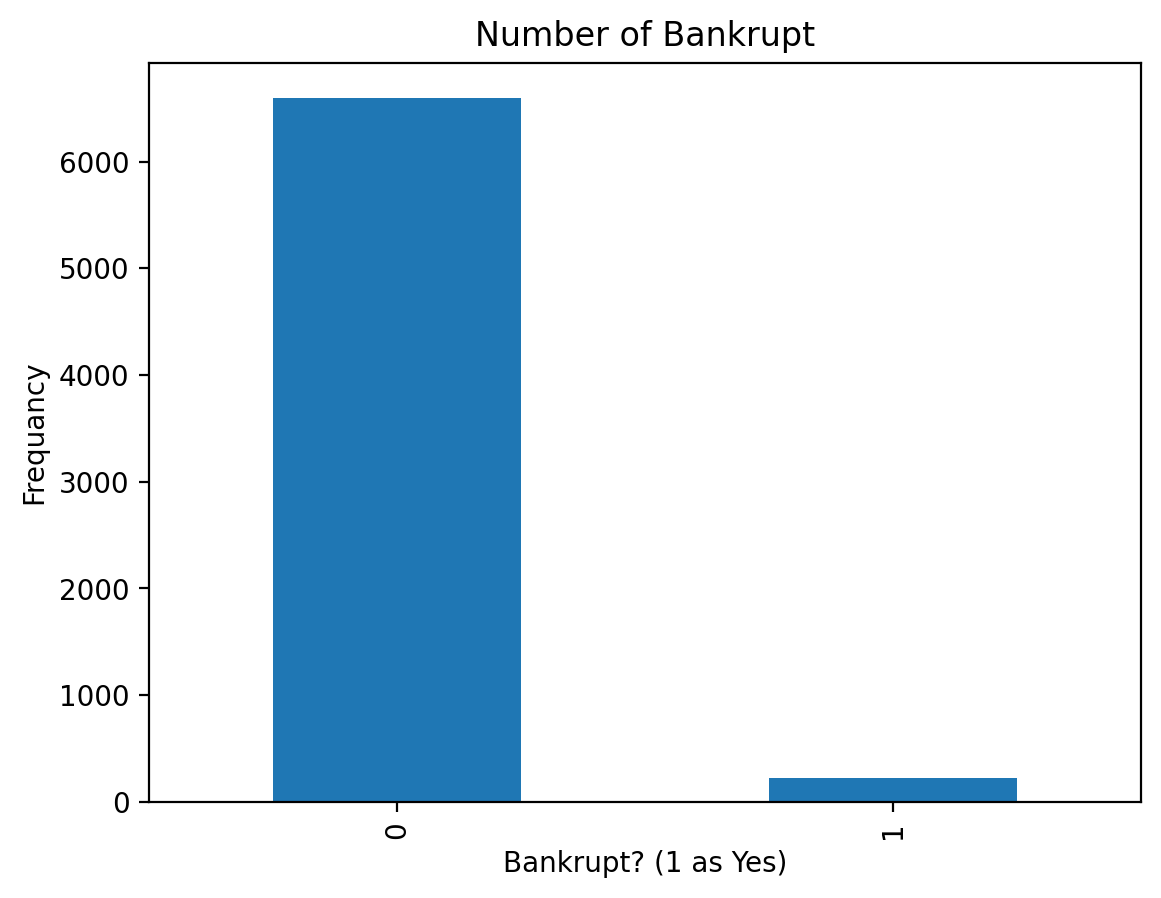

In [9]:
df1.groupby('Bankrupt?').count().iloc[:,0].plot.bar()
plt.xlabel("Bankrupt? (1 as Yes)")
plt.ylabel("Frequancy")
plt.title("Number of Bankrupt")

In [10]:
print(f"Total number of bankrupt: {df1['Bankrupt?'].value_counts()[1]} \nTotal Non-bankrupt: {df1['Bankrupt?'].value_counts()[0]}\n")
print(f"Bankruptcy rate: {len(df1[df1['Bankrupt?'] == 1])/len(df1):.4f}")

Total number of bankrupt: 220 
Total Non-bankrupt: 6599

Bankruptcy rate: 0.0323


> A couple of things we can note here:
> - The data comprises total of 6819 firms from 1999 to 2009 with 220 relevant defaults, as shown above
> - The average default rate per year is about 220/(1298) =0.0323 or 3.23%. This is small but not atypical for firms in a well-developed economy.

Since we manually construct the SVB data frame, the data is pretty clean. 
For later testing of our prediction model, we calculated the necessary variables for the SVB dataset:

In [51]:
SVB[' Debt ratio %'] = SVB['Total liabilities($B)']/SVB['Total assets($B)']
SVB[' Net worth/Assets'] = SVB['Total SVBFG stockholders equity (=net worth)($B)']/SVB['Total assets($B)']
SVB[" Net Income to Stockholder's Equity"] = SVB['Net income before noncontrolling interests($B)']/SVB['Total SVBFG stockholders equity (=net worth)($B)']
SVB

,Total liabilities($B),Total assets($B),Net income before noncontrolling interests($B),Total SVBFG stockholders equity (=net worth)($B),Debt ratio %,Net worth/Assets,Net Income to Stockholder's Equity
SVB_2022_Financials,195.498,19.679,1.609,16.004,9.934346,0.813253,0.100537
SVB_2021_Financials,195.498,19.679,1.609,16.004,9.934346,0.813253,0.100537


### 2. Data Exploration - Patterns & Relationships

We will look closer at df1 by exploring the relationships between main variables for later constructing a bankruptcy prediction model.

Usually, when a firm goes bankrupt, we doubt its financial situation - borrowing too much or insufficient investments, and its operation situation. So, given such as large dataset, we roughly have the variables (columns) subgroup into three categories:

1. **Debt** with six variables that primarily focus on total debt
2. **Operations** with six variables that pertain to the firm's operations and cash flows
3. **Equity** with six variables that relate to the firm's equity and shares

-  We will explore specific relationships between bankrupts with variables within each category.

In [11]:
df1_debt = df1[['Bankrupt?',' Degree of Financial Leverage (DFL)',' Debt ratio %', ' Total debt/Total net worth', ' Liability to Equity', ' Interest-bearing debt interest rate', ' Interest Expense Ratio']]

df1_cashflow = df1[['Bankrupt?',' Operating Profit Rate', ' Operating Expense Rate',' Cash flow rate',  ' Cash/Total Assets', ' Net worth/Assets', ' Total Asset Growth Rate']]

df1_equity = df1[['Bankrupt?', ' Persistent EPS in the Last Four Seasons', ' Revenue Per Share (Yuan ¥)', ' Working Capital/Equity', ' Cash Flow to Equity', " Net Income to Stockholder's Equity", ' Equity to Liability']]

#### Exploring Correlation & Patterns
Look closely at each data category; Plot the correlation matrix on the numerical attributes; Plot bar chats by groups.

#### (1) For main Debt Variables:

In [12]:
df1_debt.describe()

,Bankrupt?,Degree of Financial Leverage (DFL),Debt ratio %,Total debt/Total net worth,Liability to Equity,Interest-bearing debt interest rate,Interest Expense Ratio
count,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000
mean,0.032263,0.027541,0.113177,4.416337e+06,0.280365,1.644801e+07,0.630991
std,0.176710,0.015668,0.053920,1.684069e+08,0.014463,1.082750e+08,0.011238
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,0.000000,0.026791,0.072891,3.007049e-03,0.276944,2.030200e-04,0.630612
50%,0.000000,0.026808,0.111407,5.546284e-03,0.278778,3.210320e-04,0.630698
75%,0.000000,0.026913,0.148804,9.273292e-03,0.281449,5.325530e-04,0.631125
max,1.000000,1.000000,1.000000,9.940000e+09,1.000000,9.900000e+08,1.000000


Text(0.5, 1.0, 'Correlation Heatmap bewteen Bankrupt and Debt variables')

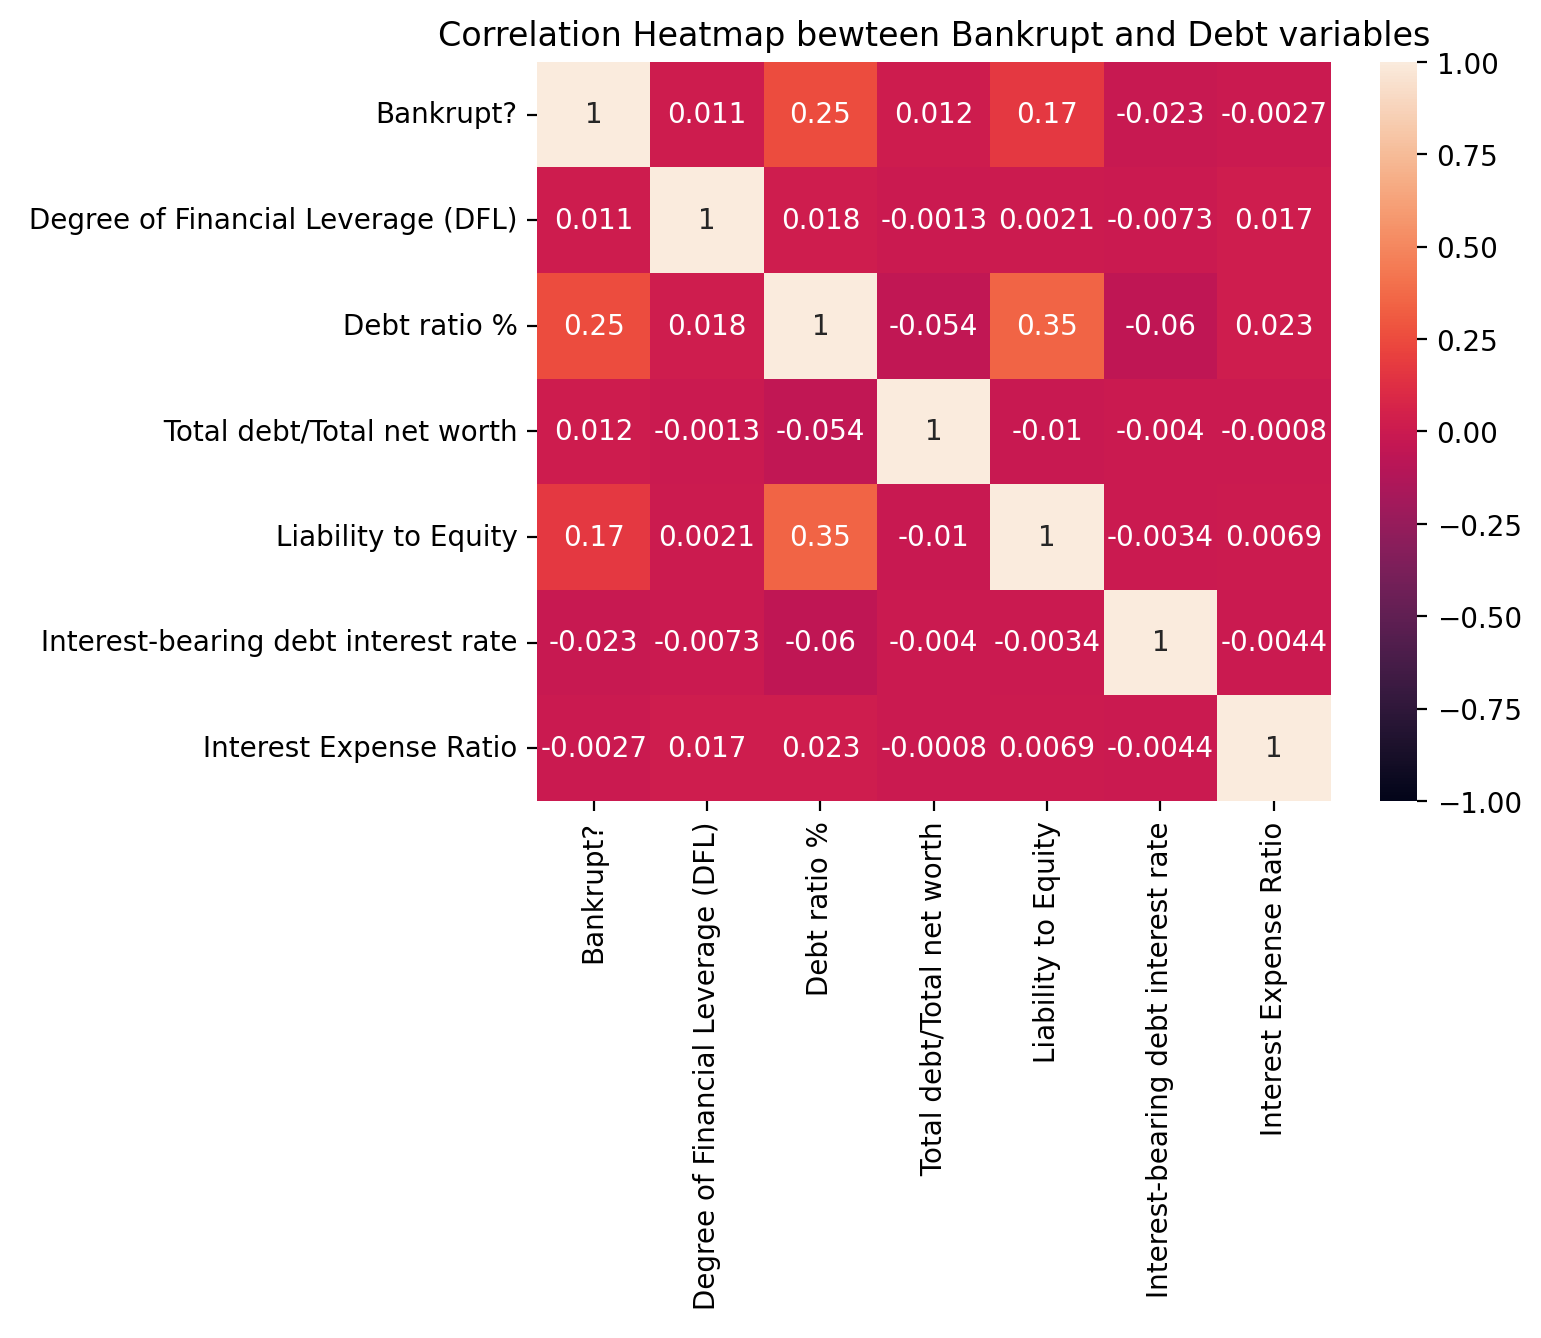

In [13]:
heatmap = sns.heatmap(df1_debt.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap bewteen Bankrupt and Debt variables')

- The correlation heatmap above clearly indicates positive associations between bankruptcy and Debt ratio %, and Liability to Equity.
- Debt ratio % has the highest correlation with bankruptcy.
- This signals that debt can have a reasonably strong implication for firm bankruptcy - allowing us to build a prediction model using the debt variables.

Below is a brief visualization of bankruptcy by main debt variables (mean value):

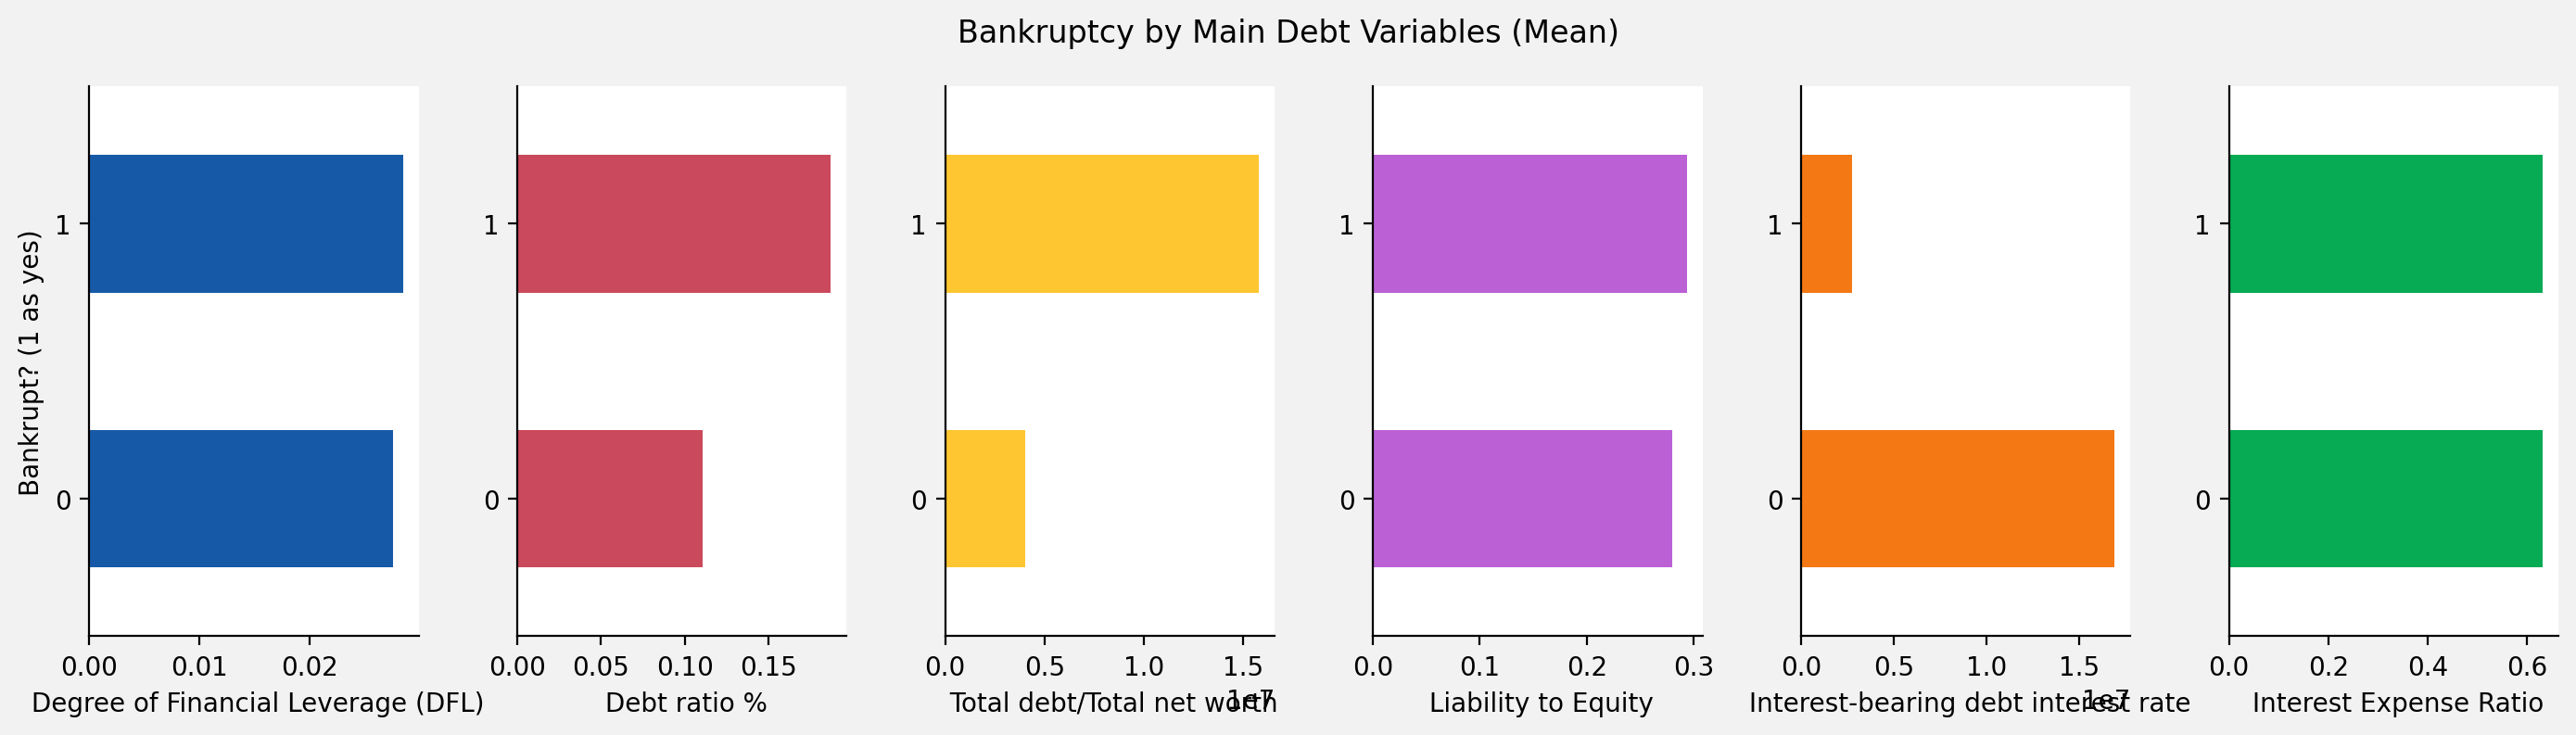

In [14]:
df1_debt_group = df1_debt.groupby('Bankrupt?').mean()


fig, ax = plt.subplots(1,6, figsize=(14,4))

bgcolor = (0.95, 0.95, 0.95)
fig.set_facecolor(bgcolor)

color = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']
for i in range(6):
    df1_debt_group[df1_debt_group.columns[i]].plot(kind="barh", ax=ax[i], color=color[i])
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel(df1_debt_group.columns[i])
    ax[i].set_ylabel(' ')

ax[0].set_ylabel('Bankrupt? (1 as yes)')
fig.suptitle('Bankruptcy by Main Debt Variables (Mean)')
fig.tight_layout()
plt.show()  

- Clear imbalance in the variables of the Debt ratio, Total debt/Total net worth, and Interet-bearing debt interest rate.

#### (2) Main Operation Variables:

In [15]:
df1_cashflow.describe()

,Bankrupt?,Operating Profit Rate,Operating Expense Rate,Cash flow rate,Cash/Total Assets,Net worth/Assets,Total Asset Growth Rate
count,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03
mean,0.032263,0.998755,1.995347e+09,0.467431,0.124095,0.886823,5.508097e+09
std,0.176710,0.013010,3.237684e+09,0.017036,0.139251,0.053920,2.897718e+09
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.998969,1.566870e-04,0.461558,0.033543,0.851196,4.860000e+09
50%,0.000000,0.999022,2.777590e-04,0.465080,0.074887,0.888593,6.400000e+09
75%,0.000000,0.999095,4.145000e+09,0.471004,0.161073,0.927109,7.390000e+09
max,1.000000,1.000000,9.990000e+09,1.000000,1.000000,1.000000,9.990000e+09


Text(0.5, 1.0, 'Correlation Heatmap bewteen Bankrupt and Operation Variables')

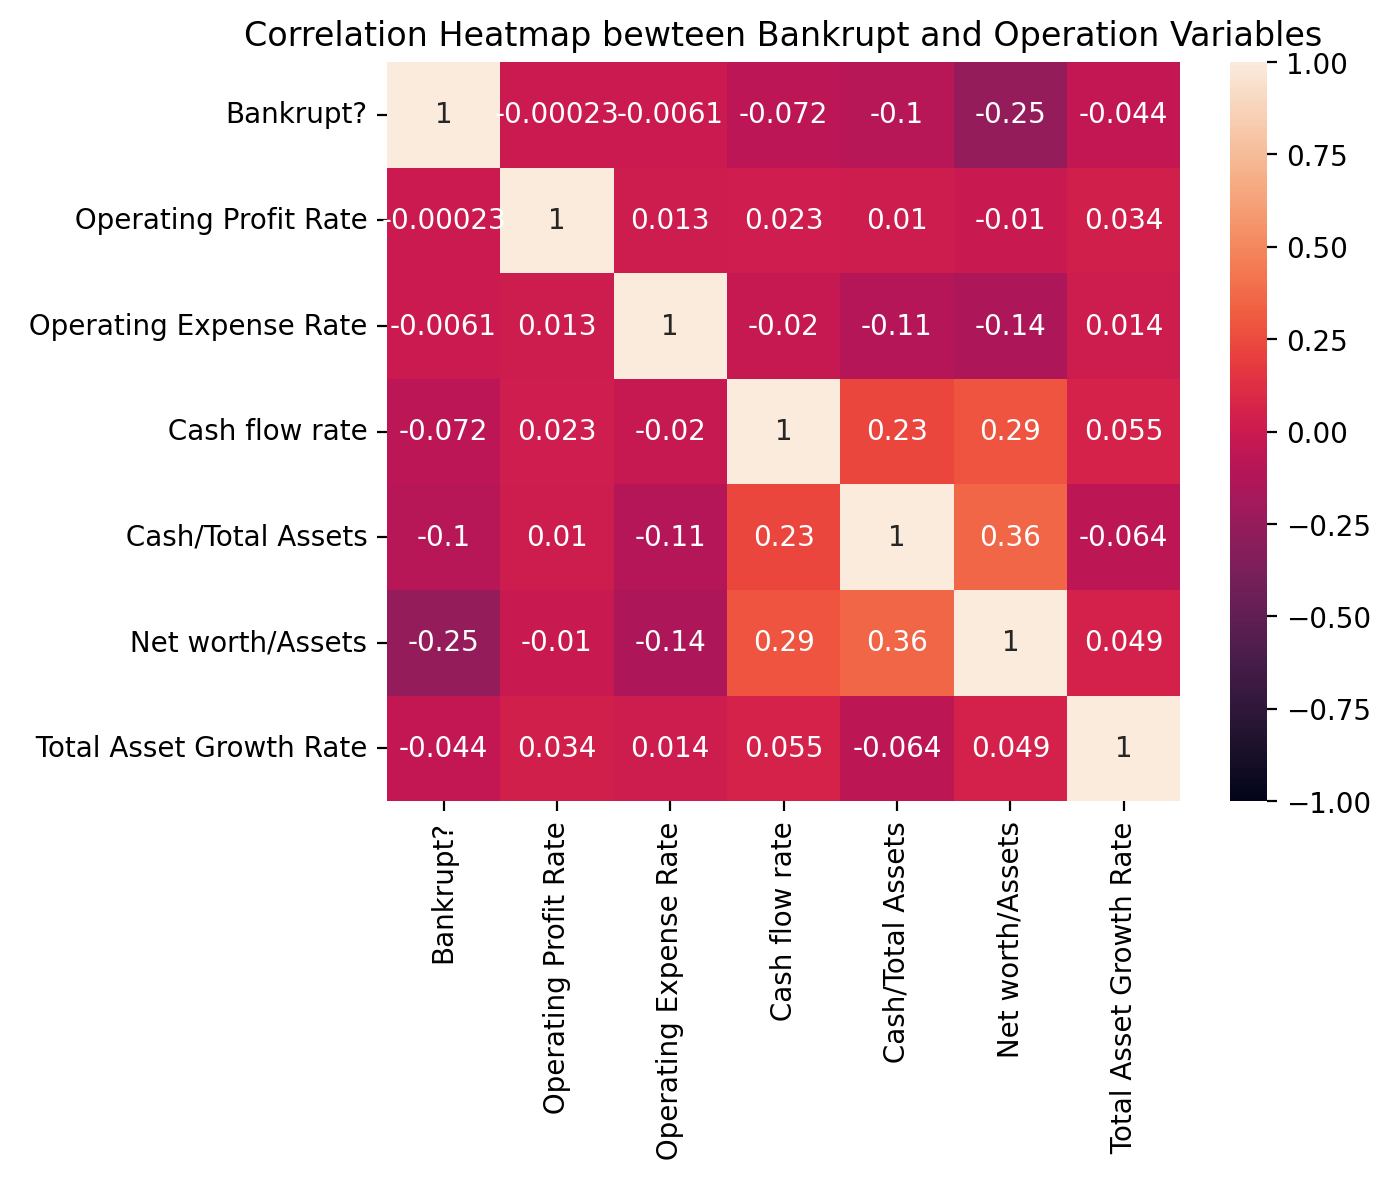

In [16]:
heatmap = sns.heatmap(df1_cashflow.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap bewteen Bankrupt and Operation Variables')

- From above, we mainly see Negative Correlations between bankruptcy and a firm's operation situation - suggesting a higher likelihood of default if a firm has unhealthy operation or cash shortages. Specifically, we see Cash/Total Assets and Net worth/Assets ratios have stronger negative impact.
- Net worth/Assets has the greatest correlation with bankruptcy.

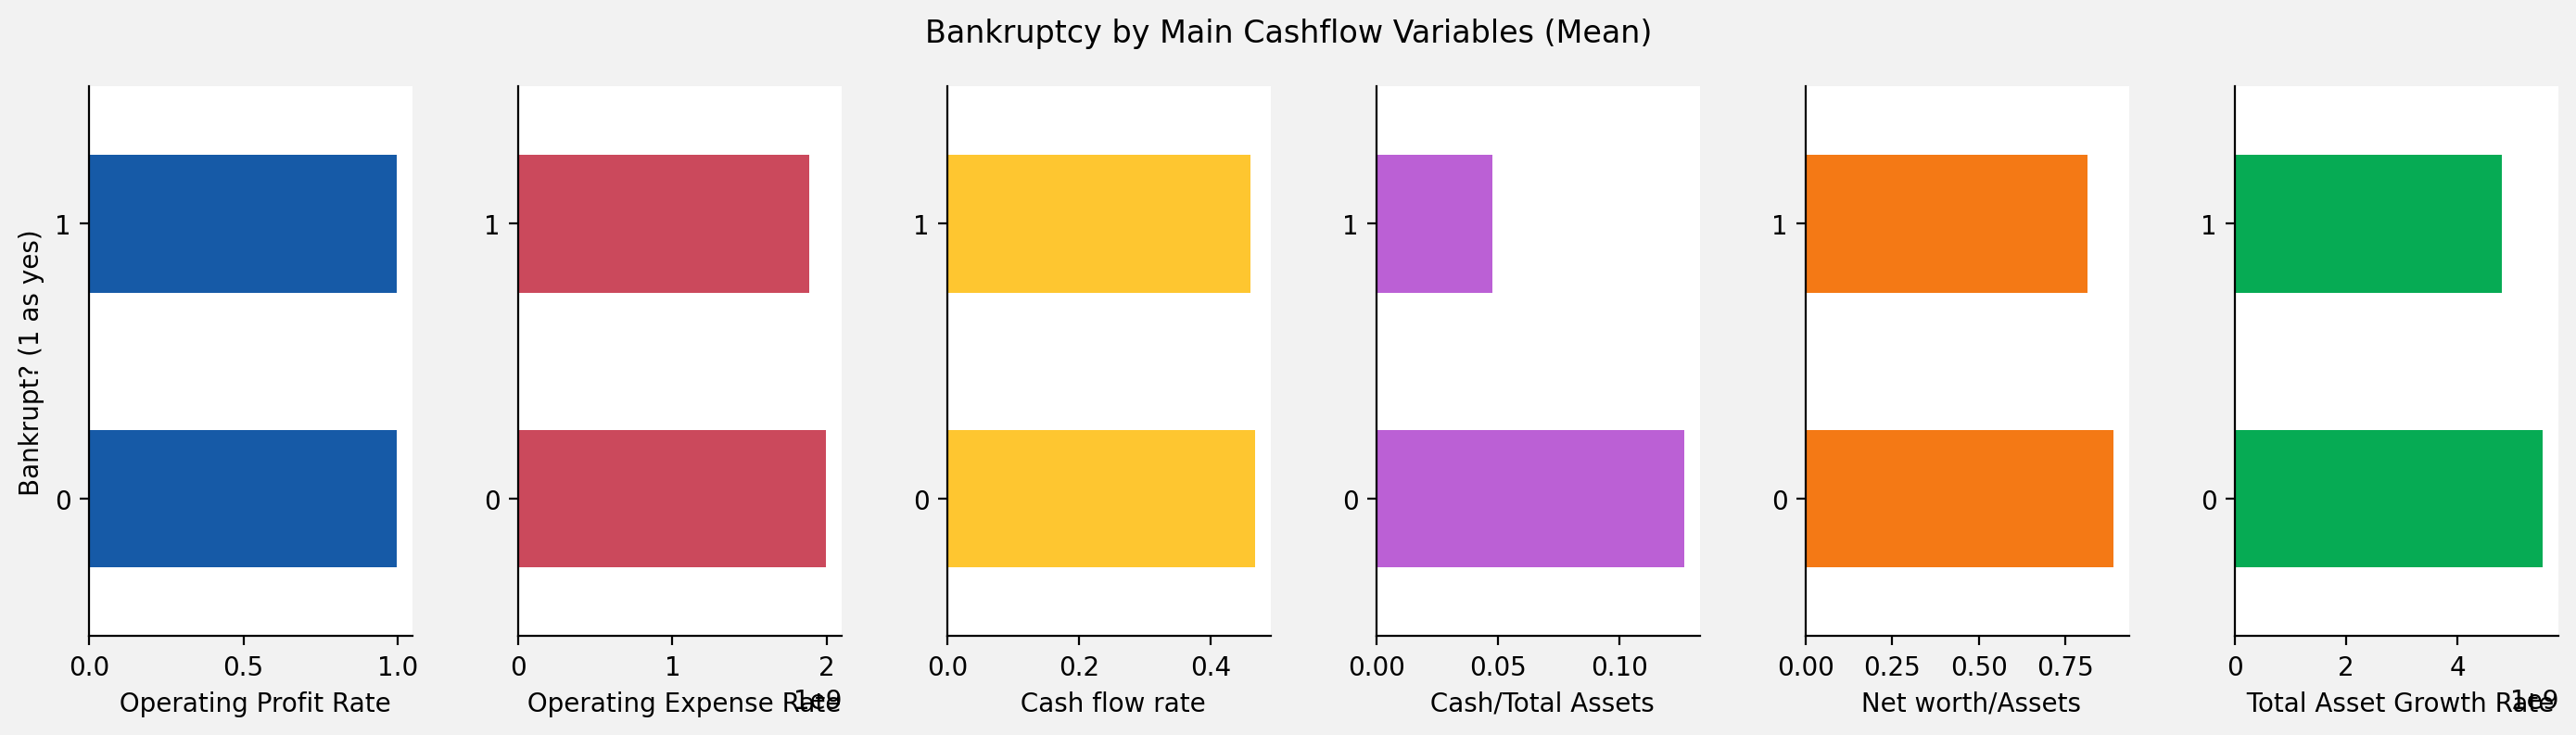

In [17]:
df1_cashflow_group = df1_cashflow.groupby('Bankrupt?').mean()

fig, ax = plt.subplots(1,6, figsize=(14,4))

fig.set_facecolor(bgcolor)

for i in range(6):
    df1_cashflow_group[df1_cashflow_group.columns[i]].plot(kind="barh", ax=ax[i], color=color[i])
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel(df1_cashflow_group.columns[i])
    ax[i].set_ylabel(' ')

ax[0].set_ylabel('Bankrupt? (1 as yes)')
fig.suptitle('Bankruptcy by Main Cashflow Variables (Mean)')
fig.tight_layout()
plt.show()

- Clear Imbalance between Bankrupt and Cash-to-Total-Asset ratio.

####  (3) Main Equity Vairables:

In [18]:
df1_equity.describe()

,Bankrupt?,Persistent EPS in the Last Four Seasons,Revenue Per Share (Yuan ¥),Working Capital/Equity,Cash Flow to Equity,Net Income to Stockholder's Equity,Equity to Liability
count,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.032263,0.228813,1.328641e+06,0.735817,0.315582,0.840402,0.047578
std,0.176710,0.033263,5.170709e+07,0.011678,0.012961,0.014523,0.050014
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.214711,1.563138e-02,0.733612,0.312995,0.840115,0.024477
50%,0.000000,0.224544,2.737571e-02,0.736013,0.314953,0.841179,0.033798
75%,0.000000,0.238820,4.635722e-02,0.738560,0.317707,0.842357,0.052838
max,1.000000,1.000000,3.020000e+09,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

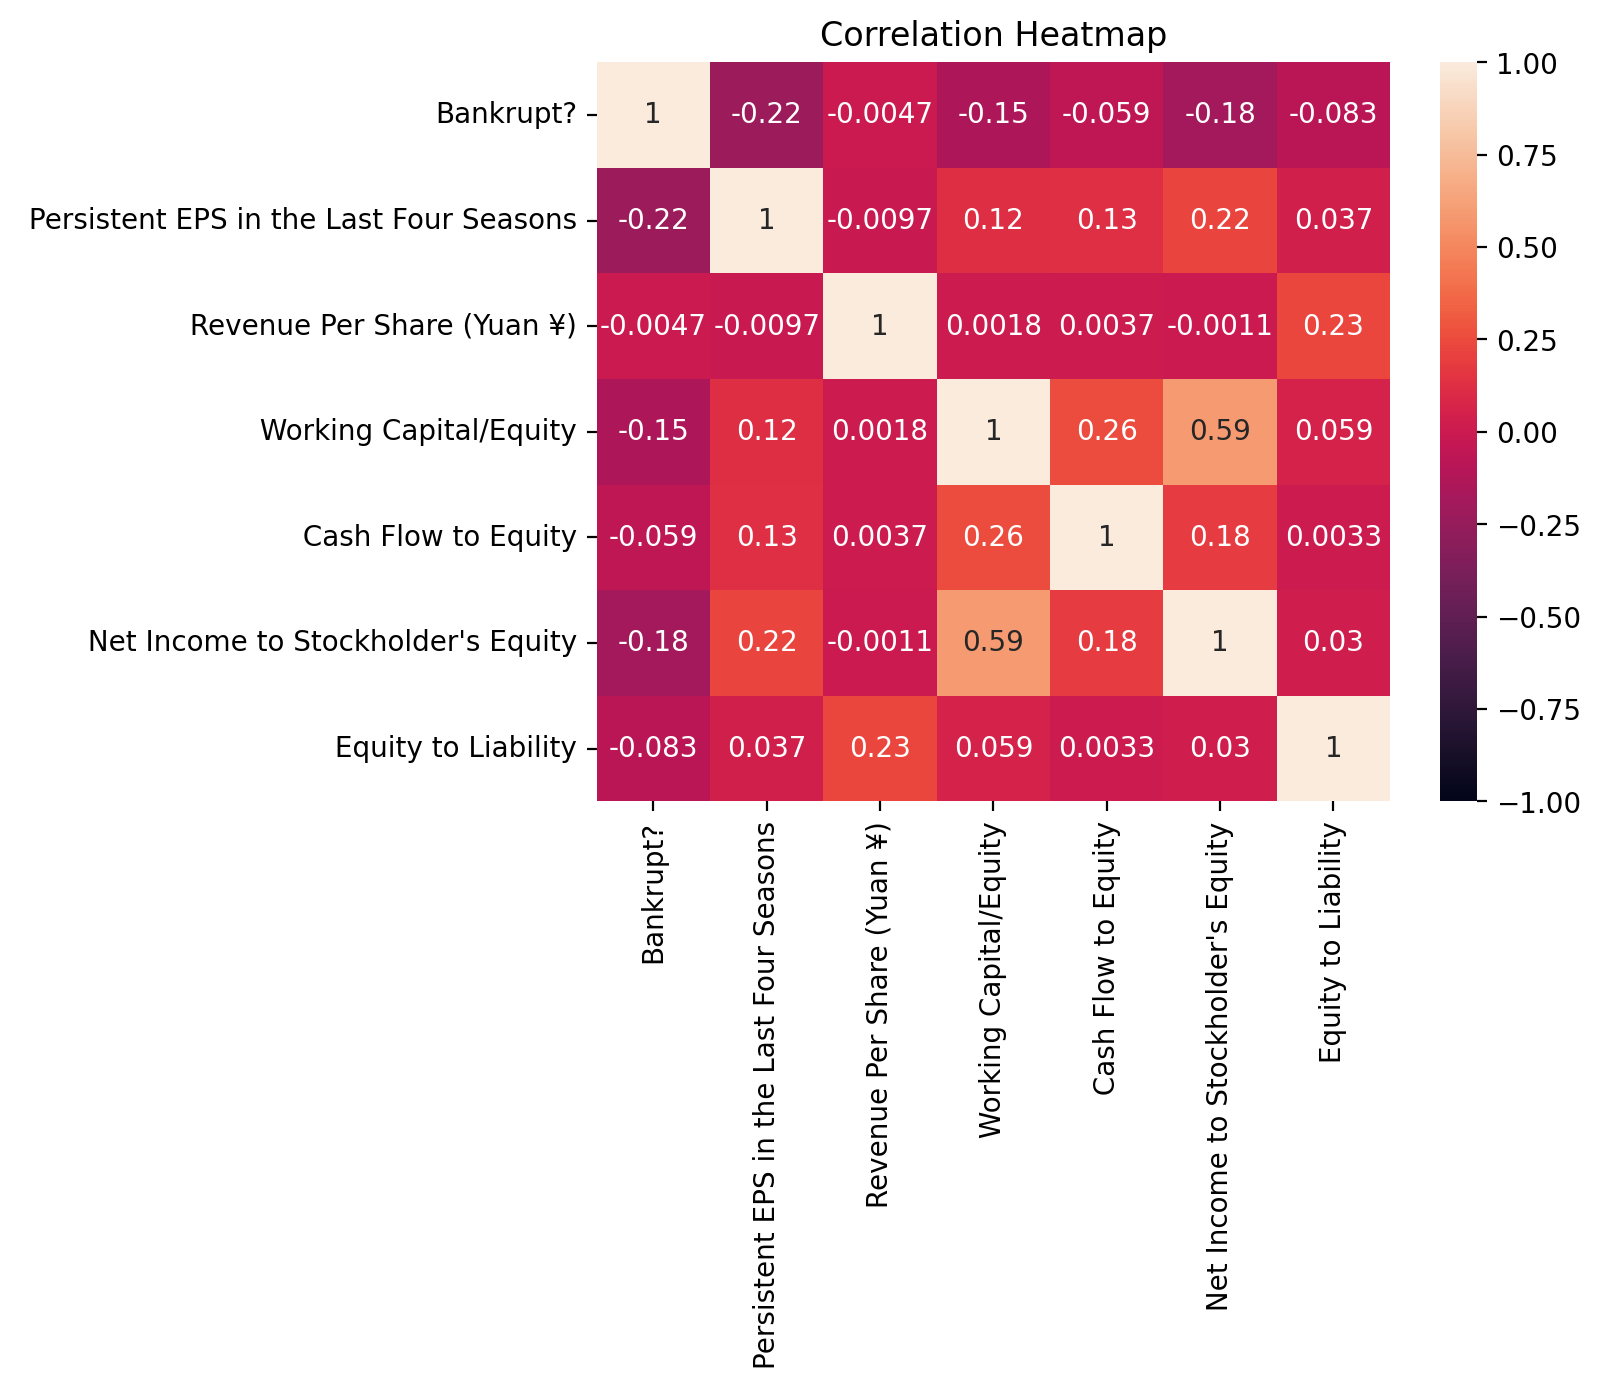

In [19]:
heatmap = sns.heatmap(df1_equity.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap')

- Clear negative association between bankruptcy and equity variables.
- Net income to Stockholder's Equity has the greatest correlation with bankruptcy.

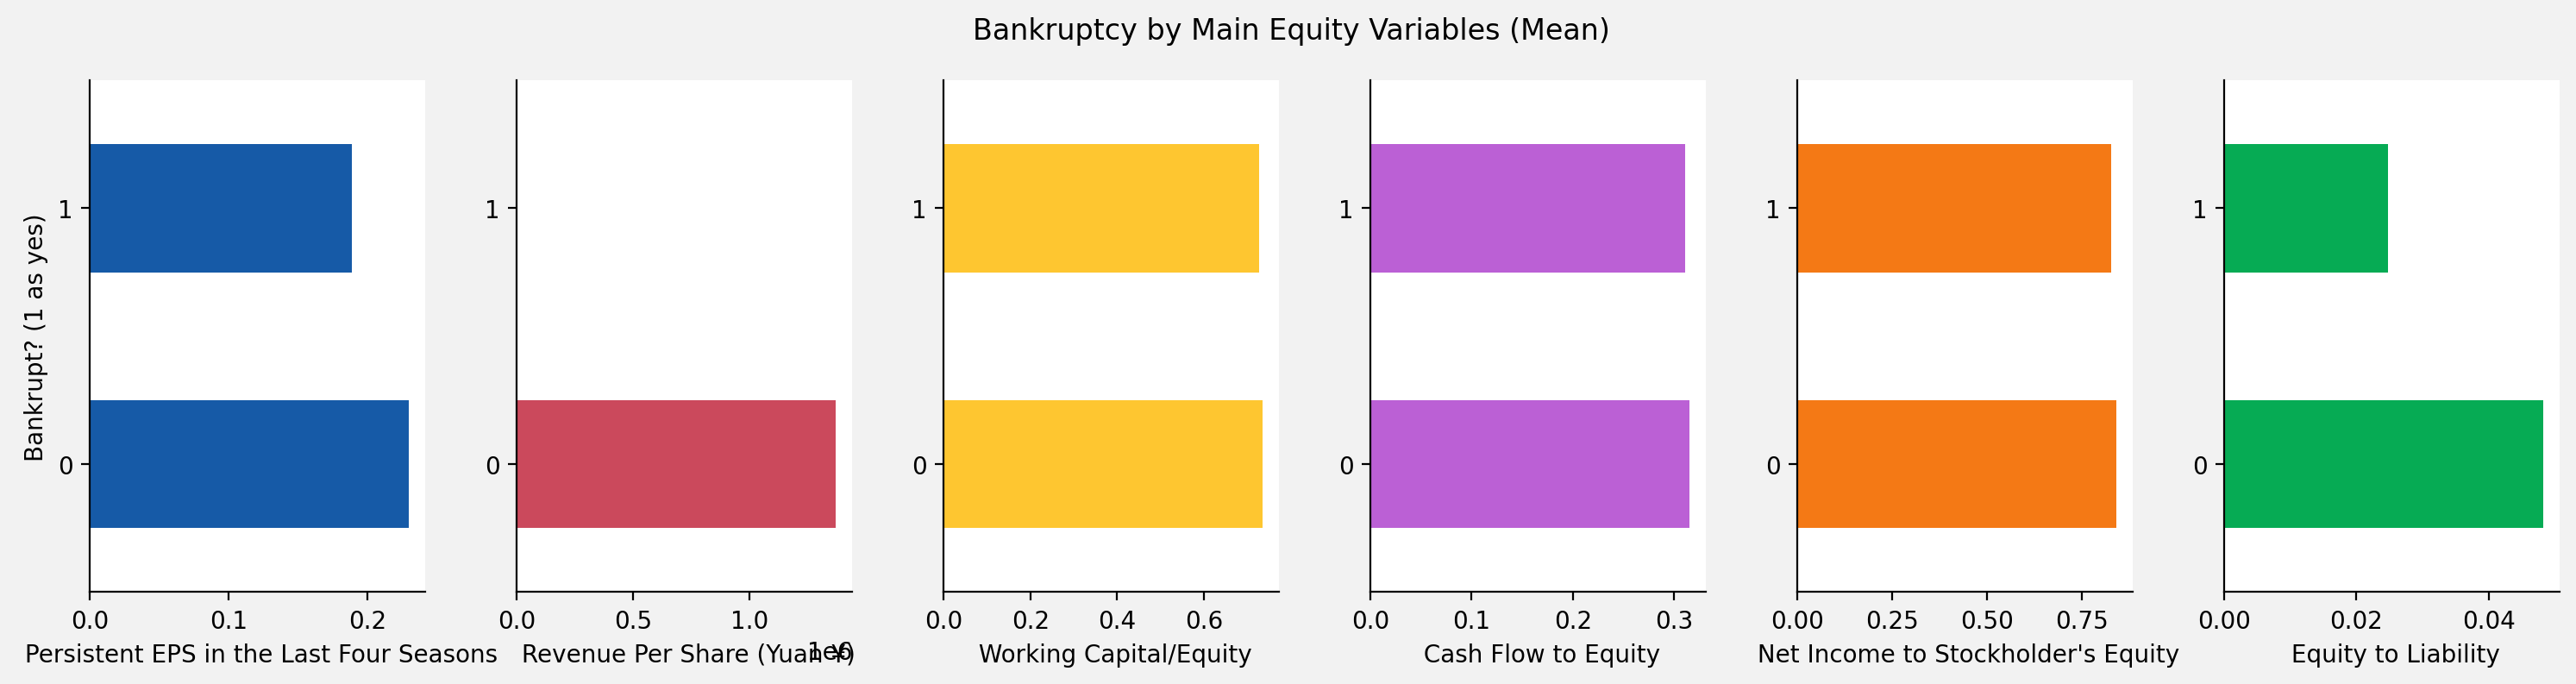

In [20]:
df1_equity_group = df1_equity.groupby('Bankrupt?').mean()

fig, ax = plt.subplots(1,6, figsize=(15,4))

fig.set_facecolor(bgcolor)

for i in range(6):
    df1_equity_group[df1_equity_group.columns[i]].plot(kind="barh", ax=ax[i], color=color[i])
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel(df1_equity_group.columns[i])
    ax[i].set_ylabel(' ')

ax[0].set_ylabel('Bankrupt? (1 as yes)')
fig.suptitle('Bankruptcy by Main Equity Variables (Mean)')
fig.tight_layout()
plt.show()

- Large imbalance in variables of Revenue per share and Equity to liability.

> Some of the above variables (i.e., Debt ratio%, Net worth/Assets, and Net Income to Stockholder's Equity) can provide signals for firm bankruptcy, allowing us to build a predictive model.

##### To better model a binary dependent variable, below, we try Logistic Regression and classificationion.

### 3. Logistic (Logit) Regression ###

A logistic regression allows us to use the logistic function 
$$
L(x) = \frac{1}{1 + e^{-(\beta_1x + \beta_0)}}
$$
as a means to identify the probability of an event happening given a set of points. The data should produce binary results which suits our case of predicting the likelihood of bankruptcy. The logistic regression can then be used to produce a logistic function on which a point on the function corresponds with the probability that an event will happen or not happen. We can also take this a step further and predict whether or not a company will go bankrupt, depending on the probability of it happening.

#### 3.1 Fit a Logistic Model  

- To better fit a logistic model, we selected variables with the most correlation with bankruptcy from each category: **Debt ratio %, Net worth/Assets, and Net Income to Stockholder's Equity.**

- We will **fit a logistic model on each variable and all variables combined**. The reason for this is that we want to see the effect of a single variable on bankruptcies and multiple variables on bankruptcies.

In [21]:
X = df1[[' Debt ratio %', ' Net worth/Assets',  " Net Income to Stockholder's Equity"]]
Y = df1['Bankrupt?']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.40, random_state=42)

Multi_logistic_model = linear_model.LogisticRegression(solver="lbfgs")
Multi_logistic_model.fit(X_train, y_train)

beta0 = Multi_logistic_model.intercept_[0]
beta1, beta2, beta3 = Multi_logistic_model.coef_[0]
print(f"Multivariate Fit model: \np(recid) = L({beta0:.4f} + ({beta1:.4f} Debt ratio %) + ({beta2:.4f} Net worth/Assets) + ({beta3:.4f} Net Income to Stockholder's Equity))")

Multivariate Fit model: 
p(recid) = L(1.3789 + (4.6832 Debt ratio %) + (-4.6832 Net worth/Assets) + (-1.5587 Net Income to Stockholder's Equity))


- This corresponds with our expectation: higher debt means higher bankruptcy probability, whereas worsening operations or lower equity signals higher bankruptcy probability.
- Both Debt ratio and Net worth/Assets highly forecast bankruptcy.

#### To see the effect of each variable on bankruptcy:

In [23]:
X_train_debt, X_test_debt, y_train, y_test = model_selection.train_test_split(X[[' Debt ratio %']], Y, test_size=0.40, random_state=42)

logistic_model_debt = linear_model.LogisticRegression(solver = "lbfgs").fit(X_train_debt, y_train)

beta0_debt = logistic_model_debt.intercept_[0]
beta1_debt = logistic_model_debt.coef_[0, 0]
X_train_debt.head()

,Debt ratio %
868,0.103516
305,0.181153
1849,0.018986
5676,0.129788
1988,0.118995


In [24]:
X_train_assets, X_test_assets, y_train, y_test = model_selection.train_test_split(X[[' Net worth/Assets']], Y, test_size=0.40, random_state=42)

logistic_model_assets = linear_model.LogisticRegression(solver = "lbfgs").fit(X_train_assets, y_train)

beta0_assets = logistic_model_assets.intercept_[0]
beta1_assets = logistic_model_assets.coef_[0, 0]
X_train_assets.head()

,Net worth/Assets
868,0.896484
305,0.818847
1849,0.981014
5676,0.870212
1988,0.881005


In [25]:
X_train_equity, X_test_equity, y_train, y_test = model_selection.train_test_split(X[[" Net Income to Stockholder's Equity"]], Y, test_size=0.40, random_state=42)

logistic_model_equity = linear_model.LogisticRegression(solver = "lbfgs").fit(X_train_equity, y_train)

beta0_equity = logistic_model_equity.intercept_[0]
beta1_equity = logistic_model_equity.coef_[0, 0]
X_train_equity.head()

,Net Income to Stockholder's Equity
868,0.842560
305,0.831839
1849,0.842637
5676,0.841871
1988,0.834865


#### 3.2 Plotting the logistic regression model

We will now be plotting the logistic regression using bokeh. Feel free to manipulate the plots to get information.

In [26]:
def logistic(b1, b0, x):
    # ret = [1/(1 + math.exp(-(b0 + b1*i))) for i in x]
    ret = [b0 + b1*i for i in x]
    ret = expit(ret)
    return ret

def inv_logistic(b1, b0, thresh):
    return (-math.log((1/thresh) - 1) - b0)/b1


In [27]:
output_notebook()

def logit_bkh(X, y, b1, b0, b1mix, b0mix, xlab, ylab = "Probability of Bankruptcy", thresh=0.5):

    sample = 200
    line_width = 4
    x_thresh = inv_logistic(b1, b0, thresh)
    x_thresh_mixed = inv_logistic(b1mix, b0mix, thresh)
    x_axis = np.linspace(np.min([-0.1, x_thresh - 0.1, x_thresh_mixed - 0.1]), np.max([1.1, x_thresh, x_thresh_mixed]), sample)
    # print(x_axis)
    y_logistic = logistic(b1, b0, x_axis)

    y_logistic_mixed = logistic(b1mix, b0mix, x_axis)

    data_src_uni = ColumnDataSource(data={
        'univar_y_log': y_logistic,
        'x_axis': x_axis
    })

    data_src_multi = ColumnDataSource(data={
        'multivar_y_log': y_logistic_mixed,
        'x_axis': x_axis
    })
    
    bkh = figure(title = f"Logistic Regression for {xlab} Data", x_axis_label = xlab, y_axis_label = ylab, x_range = [-0.1, 1], width = 1000, height = 500)

    bkh.add_layout(BoxAnnotation(top=thresh, fill_alpha=0.1, fill_color='red'))
    bkh.add_layout(BoxAnnotation(bottom=thresh, fill_alpha=0.1, fill_color='green'))
    bkh.add_layout(Label(y=thresh+0.3, text='Bankrupt if logistic function is in the green', text_color = 'green', text_alpha = 0.7))
    bkh.add_layout(Label(y=thresh-0.3, text='Not Bankrupt if logistic function is in the red', text_color = 'red', text_alpha = 0.7))

    if thresh != 0.5:
        bkh.line(x = x_axis, y = np.linspace(thresh, thresh, sample), color = "#cc0014", legend_label = f"optimal threshold at p={thresh}", line_width = line_width)
    bkh.line(x = x_axis, y = np.linspace(0.5, 0.5, sample), color = "#737272", legend_label = f"default threshold at p=0.5", line_dash='dashed', line_width = line_width)

    bkh.circle(x = X.to_numpy()[:, 0], y=y.to_numpy(), size=8, color="black", fill_color = "white")
    bkh.line(x = 'x_axis', y = 'univar_y_log', color = "#024bab", legend_label = f"Univariate Logistic Regression Line fitted to just {xlab}", line_width = line_width, source = data_src_uni)
    bkh.line(x = 'x_axis', y = 'multivar_y_log', color = "#00c1ff", legend_label = f"Multivarite Logistic Regression Line fitted to all variables", line_width = line_width, source = data_src_multi)
    print(x_thresh)
    bkh.circle(x=[x_thresh], y=[thresh], size=12, color="black", fill_color = "red")


    bkh.circle(x=[x_thresh_mixed], y=[thresh], size=12, color="black", fill_color = "red")
    bkh.add_layout(Arrow(end=VeeHead(line_color="black", line_width=2, fill_color='black'),
                       line_color='black', line_width=2,
                       x_end=x_thresh, y_end=thresh,
                       x_start=x_thresh, y_start= thresh + 0.2))
    bkh.add_layout(Label(x=x_axis[50], y=thresh + 0.2, text=f"if {xlab} crosses {x_thresh}, the company will go bankrupt", text_color = 'black', text_alpha = 0.7))

    bkh.add_tools(CrosshairTool())
    bkh.legend.click_policy='hide'
    bkh.add_tools(HoverTool(
        tooltips=[
            ('Probability', '@univar_y_log'),
            (f"{xlab}", '@x_axis')
        ]
    ))

    bkh.add_tools(HoverTool(
        tooltips=[
            ('Probability', '@multivar_y_log'),
            (f"{xlab}", '@x_axis')
        ]
    ))
  
  
    
    show(bkh)


logit_bkh(X_train_debt, y_train, beta1_debt, beta0_debt, beta1, beta0, "Debt ratio")
logit_bkh(X_train_assets, y_train, beta1_assets, beta0_assets, beta2, beta0, "Net worth/Assets")
logit_bkh(X_train_equity, y_train, beta1_equity, beta0_equity, beta3, beta0, "Net Income to Shareholder's Equity")


Loading BokehJS ...

0.6799865178773059


0.32001301389725695


-0.9477886395260531


> HINT: Try to hover over the logistic regression line and zoom in and out of the data points. The sidebar menu gives you options to scroll by zooming, move by dragging or zoom by box dragging

Both logistic functions plotted above seem to be underfitting for all variables. Every plot of the logistic regression looks like the model will have a very high false positive or false negative rate. This can be attributed to a couple factors: 

1. The threshold is not set properly (We will correct this in the next section). 
2. In the case of the multivariate logistic regression, this may suggest that there are many other factors at play that greatly affect the outcome, in ways that trying to view each variable independently is insufficient.

#### 3.3 Performance of the models ####

Here, we will determine how well the models are predicting bankruptcies. From above, it seems that the models are not very good at predictions yet. The emperical data will confirm this below, beginning with the multivariate model:

In [28]:
def performance(mod, testX, trainX, testy, trainy, what, ax, thresh = 0.5):

    y_pred = mod.predict(trainX)
    y_pred_test = mod.predict(testX)

    cm = metrics.confusion_matrix(testy, y_pred_test)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    ax.set_title(what + " Confusion Matrix")
    report = metrics.classification_report(
        y_test, y_pred_test,
        target_names=["No bankrupt", "Bankrupt"], zero_division = 0
    )
    print(report)
    print(f"The accuracy score for the testing data of {what} is {mod.score(testX, y_pred_test)} and training data is {mod.score(trainX, y_pred)}")

              precision    recall  f1-score   support

 No bankrupt       0.97      1.00      0.98      2637
    Bankrupt       0.00      0.00      0.00        91

    accuracy                           0.97      2728
   macro avg       0.48      0.50      0.49      2728
weighted avg       0.93      0.97      0.95      2728

The accuracy score for the testing data of Multivariable Model is 1.0 and training data is 1.0


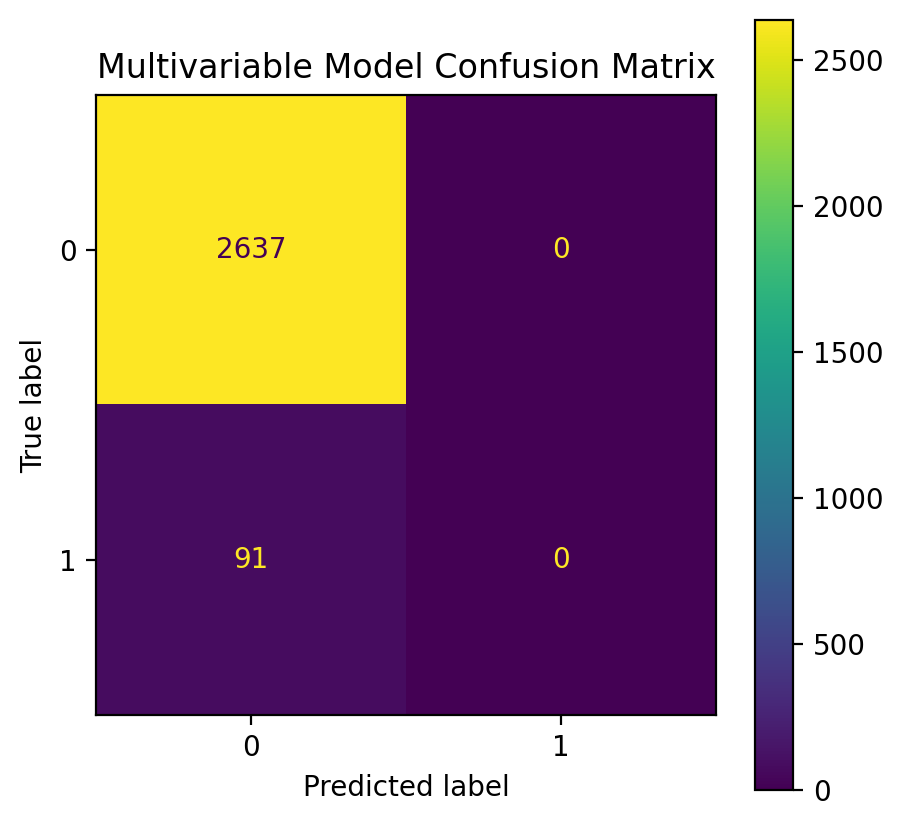

In [29]:
fig, ax = plt.subplots(figsize = (5, 5))

performance(Multi_logistic_model, X_test, X_train, y_test, y_train, "Multivariable Model", ax)

Of note from the above performance metrics:
- The testing accuracy is very similar to the training accuracy, suggesting the model might be **Underfitting**.
- As shown from the report above, the model is very good for non-bankrupt (high f1 score) but not very good for Bankrupt. This suggests difficulty in forecasting bankruptcy in real life as there could be many factors.
- From the plots of the logistic curves, it is predicting bankruptcies at levels of Debt ratio/Net worth to assets/Net income to Shareholder equity where no points exist. Therefore it will predict all points are one or the other.

Below we will be performing the same performance analysis for each univariate model.

              precision    recall  f1-score   support

 No bankrupt       0.97      1.00      0.98      2637
    Bankrupt       0.00      0.00      0.00        91

    accuracy                           0.97      2728
   macro avg       0.48      0.50      0.49      2728
weighted avg       0.93      0.97      0.95      2728

The accuracy score for the testing data of Debt Ratio is 1.0 and training data is 1.0
              precision    recall  f1-score   support

 No bankrupt       0.97      1.00      0.98      2637
    Bankrupt       0.00      0.00      0.00        91

    accuracy                           0.97      2728
   macro avg       0.48      0.50      0.49      2728
weighted avg       0.93      0.97      0.95      2728

The accuracy score for the testing data of Net Worth/Assets is 1.0 and training data is 1.0
              precision    recall  f1-score   support

 No bankrupt       0.97      1.00      0.98      2637
    Bankrupt       0.00      0.00      0.00        91

    

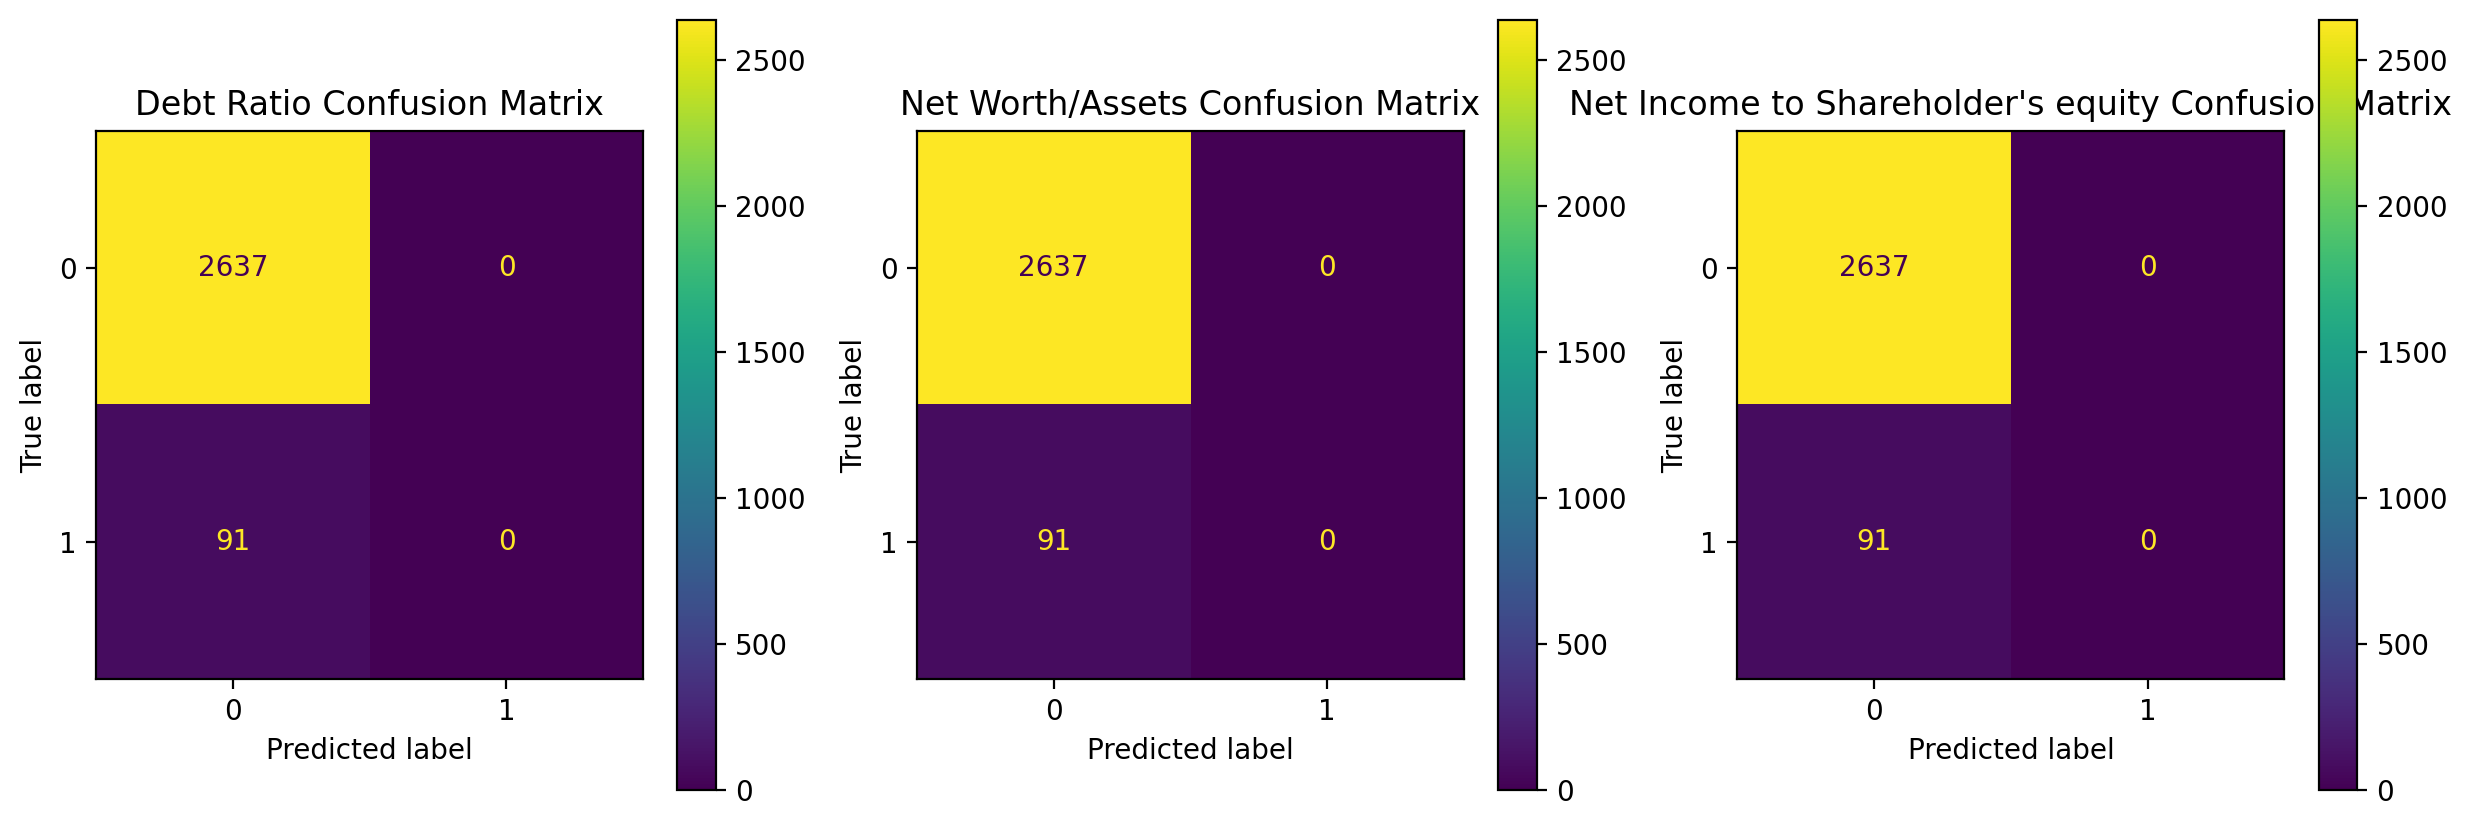

In [30]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

performance(logistic_model_debt, X_test_debt, X_train_debt, y_test, y_train, "Debt Ratio", ax[0])
performance(logistic_model_assets, X_test_assets, X_train_assets, y_test, y_train, "Net Worth/Assets", ax[1])
performance(logistic_model_equity, X_test_equity, X_train_equity, y_test, y_train, "Net Income to Shareholder's equity", ax[2])

#### 3.4 Determining a suitable threshold with an ROC curve #####

Using a ROC curve, we will determine the threshold at which we minimize the number of false positives while maximizing the true positives. It is important to minimize false positives because investors and management may use this data. The last thing anyone wants is for investors and management to be bankrupt through a self-fulfilling prophecy. 

In [31]:

def plot_roc(mod, X_test, y_test, item, ax):

    predicted_probs = mod.predict_proba(X_test)

    predicted_prob1 = predicted_probs[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob1,drop_intermediate=False)
    # get the minimized thereshold
    # print(f"the optimal threshold is {thresholds[np.argmin(np.abs(fpr+tpr-1))]}") 
    print(f"the optimal threshold for {item} is {thresholds[np.argmax(tpr-fpr)]}") 
    thresh = thresholds[np.argmax(tpr-fpr)]
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(0, 1, marker = "o")
    ax.plot(fpr, tpr)
    # ax.plot(fpr, thresholds)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{item} ROC Curve")
    return thresholds[np.argmax(tpr-fpr)]

the optimal threshold for Multivariable is 0.043352514206521565
the optimal threshold for Debt ratio is 0.039673197083172095
the optimal threshold for Net worth/Assets is 0.03967314821581268
the optimal threshold for Net Income to Shareholder's Equity is 0.03152646200520304


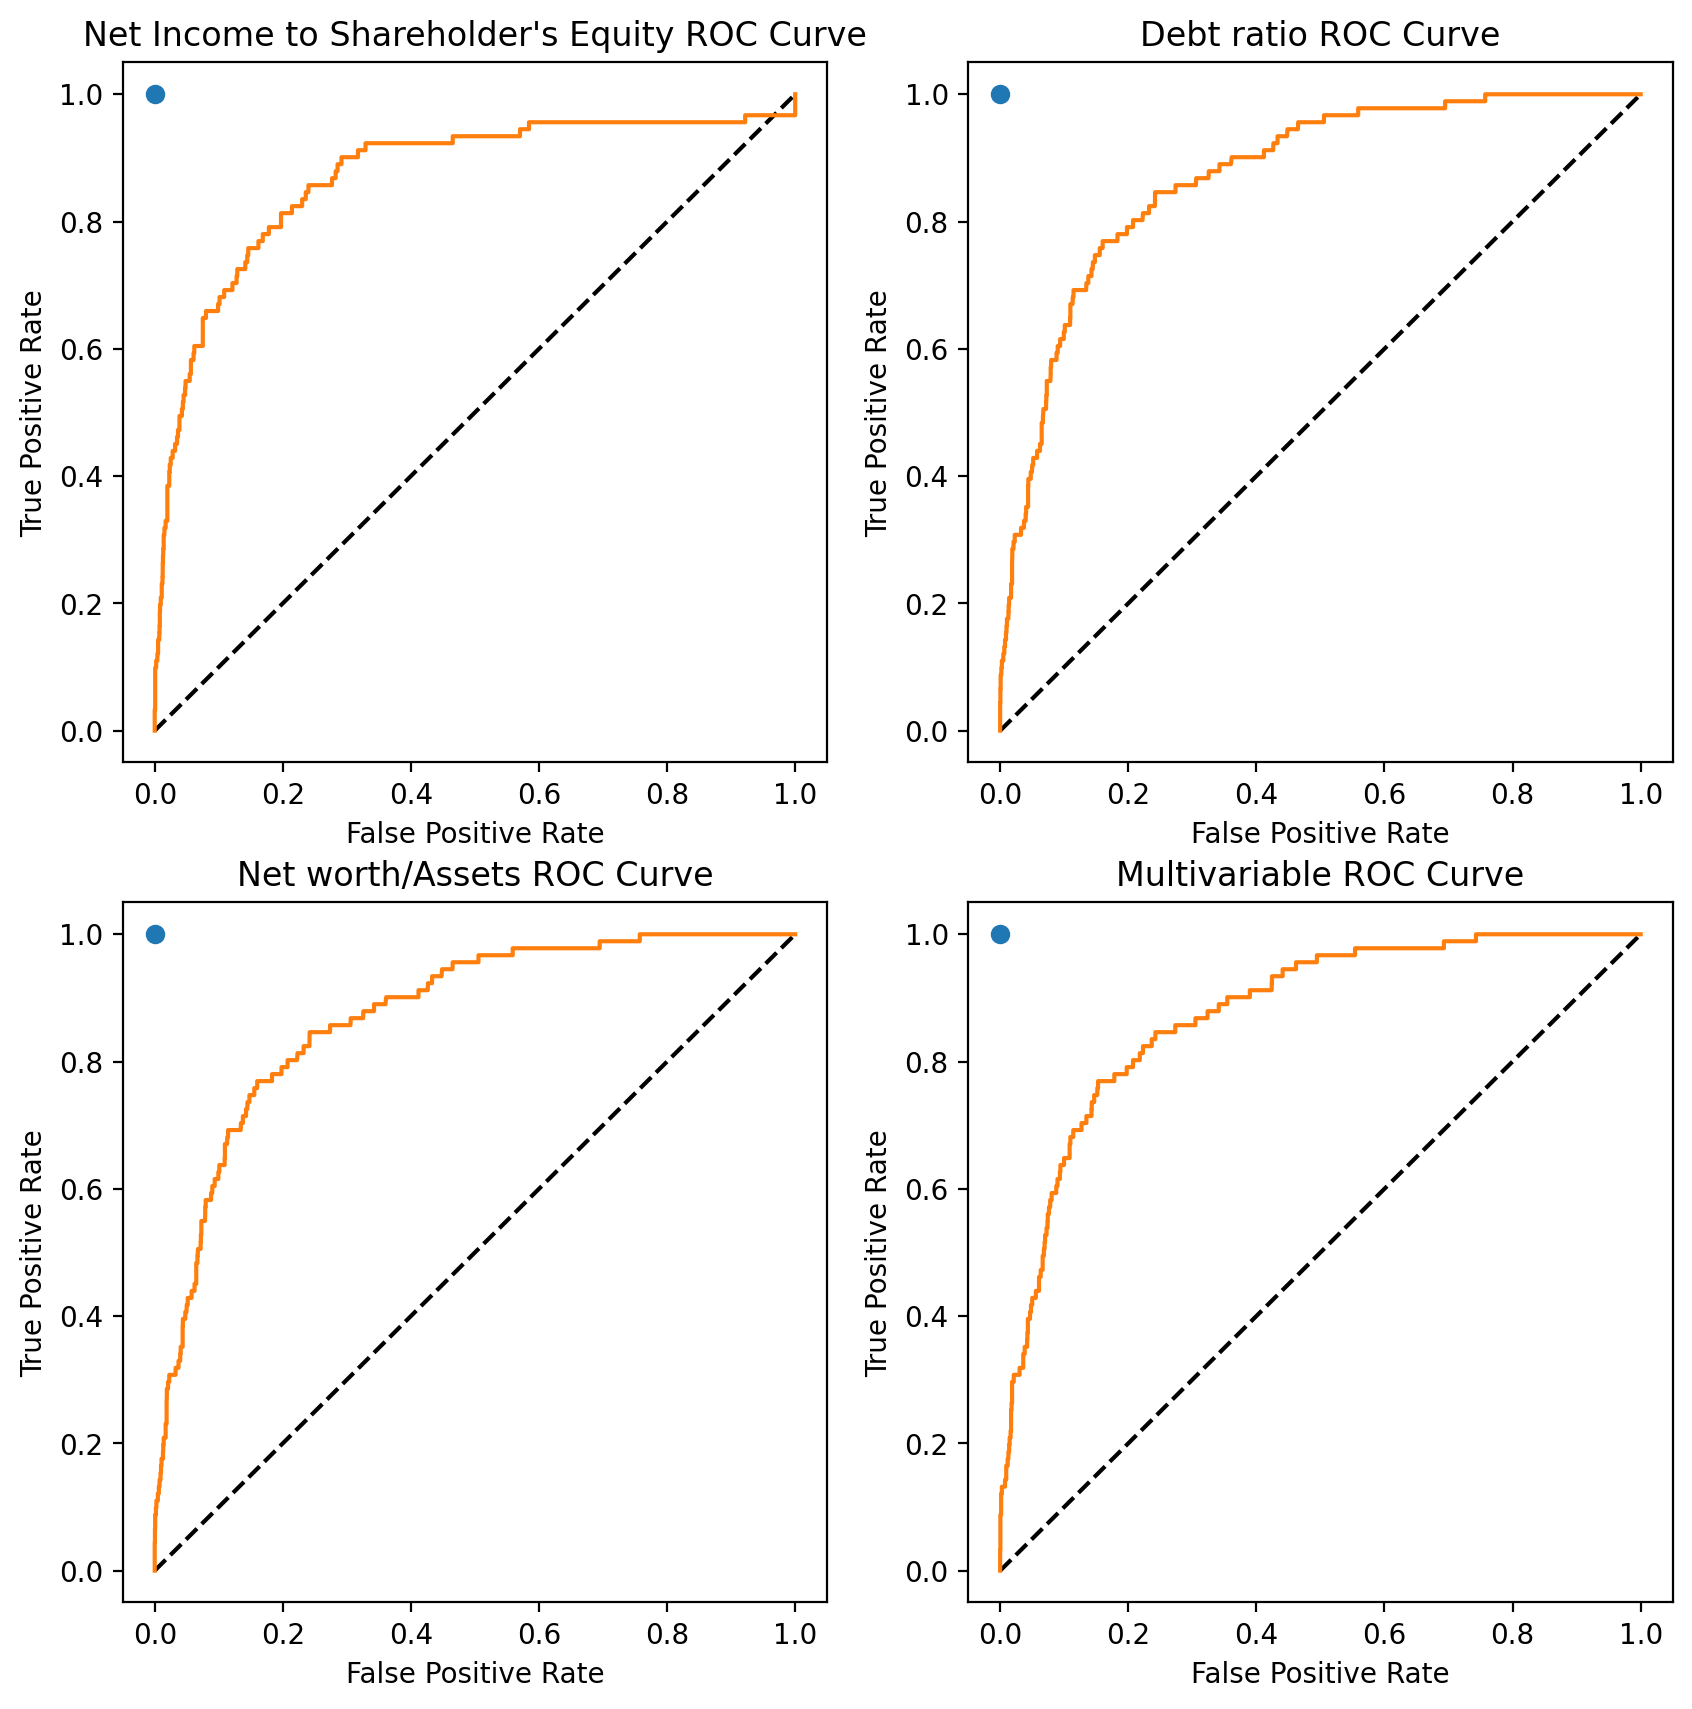

In [61]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

multi_thresh = plot_roc(Multi_logistic_model, X_test, y_test, "Multivariable", ax[1, 1])
debt_thresh = plot_roc(logistic_model_debt, X_test_debt, y_test, "Debt ratio", ax[0, 1])
assets_thresh = plot_roc(logistic_model_assets, X_test_assets, y_test, "Net worth/Assets", ax[1, 0])
equity_thresh = plot_roc(logistic_model_equity, X_test_equity, y_test, "Net Income to Shareholder's Equity", ax[0, 0])


Applying the Optimal thresholds:

In [33]:

logit_bkh(X_train_debt, y_train, beta1_debt, beta0_debt, beta1, beta0, "Debt ratio", thresh = debt_thresh)
logit_bkh(X_train_assets, y_train, beta1_assets, beta0_assets, beta2, beta0, "Net worth/Assets", thresh = assets_thresh)
logit_bkh(X_train_equity, y_train, beta1_equity, beta0_equity, beta3, beta0, "Net Income to Shareholder's Equity", thresh = equity_thresh)

0.16119962499999999


0.838800375


0.840129789


The above provides an imperfect but still more useful threshold to predict bankruptcy, at least for the univariate regression. The multivariate regressions do not appear to be able to predict bankruptcy without the other variables.

Below we will use the new threshold to test out the testing data for each variable based on the univariate regression. 
- The accuracy lowers to 82%, 82%, and 64% for the debt ratio, Net worth/Assets, and Net income to shareholder equity, respectively. While it introduces a lot more false positives, it also introduces true positives which were not seen before. 
- Furthermore, unlike before, the precision, recall, and the f1-score for bankruptcy increased, although it is still not high. 
- The accuracy also appears to be lower for the training data. Still, it all appears to be along the margin of error, so it is safe to assume that the training and testing datasets merely have similar accuracies.

In [34]:
def performance_with_threshold(mod, testX, trainX, testy,trainy, thresh, what, ax):

    predict_test = (mod.predict_proba(testX)>= thresh).astype(int)[:, 1]
    y_pred = pd.Series(index = testy.index, data=predict_test)
    # print(y_pred, y_test)
    predict_train = (mod.predict_proba(trainX)>= thresh).astype(int)[:, 1]
    y_pred_train = pd.Series(index = trainy.index, data=predict_train)

    cm = metrics.confusion_matrix(testy, y_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    ax.set_title(what + " Confusion Matrix")
    report = metrics.classification_report(
        testy, y_pred,
        target_names=["No bankrupt", "Bankrupt"]
    )
    print(report)
    print(f"The accuracy score for the testing data of {what} is {mod.score(testX, y_pred)}  and training data is {mod.score(trainX, y_pred_train)}")

              precision    recall  f1-score   support

 No bankrupt       0.99      0.84      0.91      2637
    Bankrupt       0.14      0.76      0.24        91

    accuracy                           0.84      2728
   macro avg       0.57      0.80      0.57      2728
weighted avg       0.96      0.84      0.89      2728

The accuracy score for the testing data of Debt Ratio is 0.8200146627565983  and training data is 0.8152041065754094


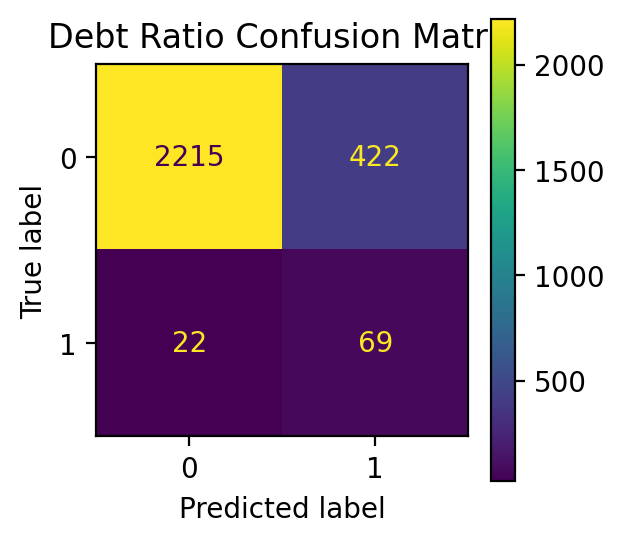

In [35]:
fig, ax = plt.subplots(figsize = (3, 3))
performance_with_threshold(logistic_model_debt, X_test_debt, X_train_debt, y_test, y_train,  0.0397, "Debt Ratio", ax)


              precision    recall  f1-score   support

 No bankrupt       0.99      0.84      0.91      2637
    Bankrupt       0.14      0.76      0.24        91

    accuracy                           0.84      2728
   macro avg       0.57      0.80      0.57      2728
weighted avg       0.96      0.84      0.89      2728

The accuracy score for the testing data of Net Worth/Assets is 0.8200146627565983  and training data is 0.8152041065754094


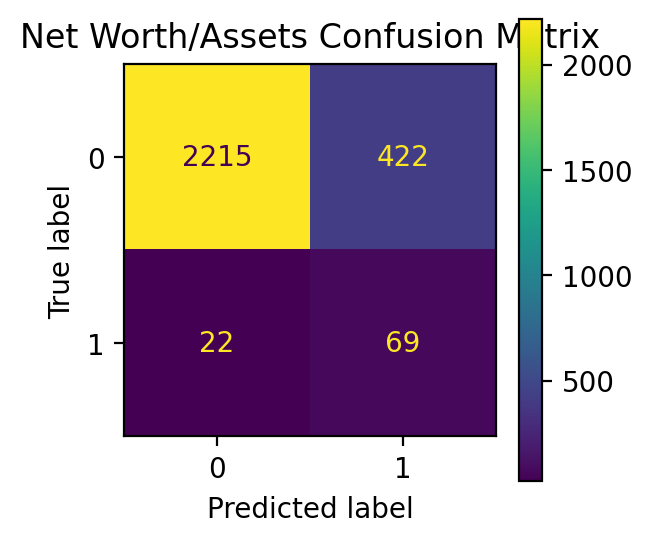

In [36]:
fig, ax = plt.subplots(figsize = (3, 3))
performance_with_threshold(logistic_model_assets, X_test_assets, X_train_assets, y_test, y_train, 0.0397, "Net Worth/Assets", ax)

              precision    recall  f1-score   support

 No bankrupt       1.00      0.66      0.79      2637
    Bankrupt       0.08      0.92      0.16        91

    accuracy                           0.67      2728
   macro avg       0.54      0.79      0.47      2728
weighted avg       0.97      0.67      0.77      2728

The accuracy score for the testing data of Net income to Shareholder's Equity is 0.6370967741935484  and training data is 0.6521632852603275


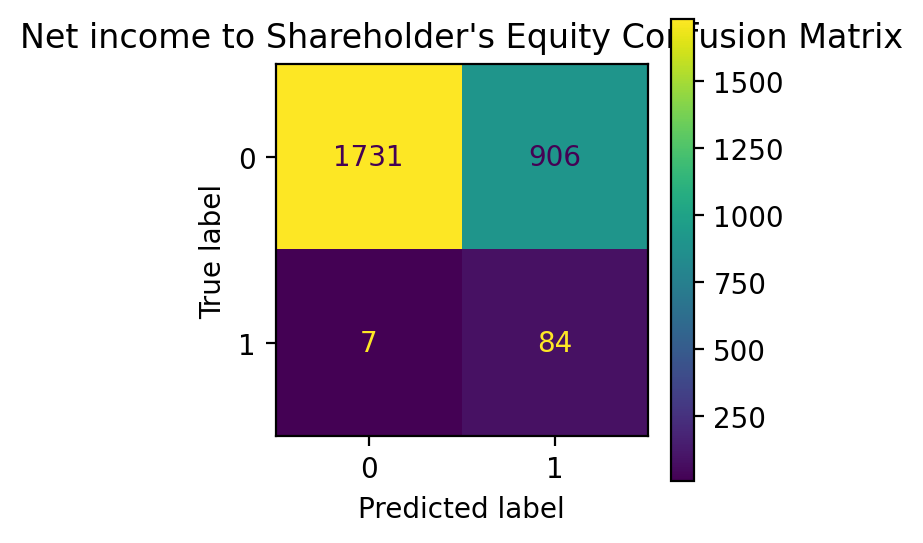

In [37]:
fig, ax = plt.subplots(figsize = (3, 3))
performance_with_threshold(logistic_model_equity, X_test_equity, X_train_equity, y_test,y_train, 0.0315, "Net income to Shareholder's Equity", ax)

Finally let's do the same thing using the multivariate classifier. This also resulted in a now non-zero precision, recall and f1-score.

              precision    recall  f1-score   support

 No bankrupt       0.99      0.85      0.91      2637
    Bankrupt       0.15      0.77      0.25        91

    accuracy                           0.84      2728
   macro avg       0.57      0.81      0.58      2728
weighted avg       0.96      0.84      0.89      2728

The accuracy score for the testing data of Multivariate Model is 0.8251466275659824  and training data is 0.8215595208995355


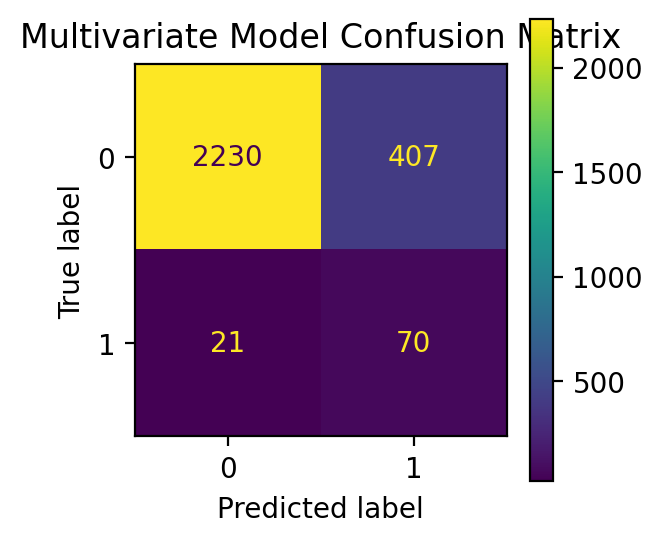

In [38]:
fig, ax = plt.subplots(figsize = (3, 3))
performance_with_threshold(Multi_logistic_model, X_test, X_train, y_test, y_train,  0.0433, "Multivariate Model", ax)

The accuracy scores and other measures of performance are unfortunately sub-par for predicting bankruptcy and the models are underfitted. One major reason we can think of is simply that bankrutpcies can be caused by many different factors and to limit it to the three which have the highest correlation may be insufficient to predict bankruptcy.

### 4. Applying the Model on SVB data

Now we have our prediction models; we want to see if they apply to a U.S. firm and if they can accurately forecast SVB's default in 2023. As we did above, we will do this beginning with the multivariate classification model and then with each variable individually.

In [40]:
SVB

,Total liabilities($B),Total assets($B),Net income before noncontrolling interests($B),Total SVBFG stockholders equity (=net worth)($B),Debt ratio %,Net worth/Assets,Net Income to Stockholder's Equity
SVB_2022_Financials,195.498,19.679,1.609,16.004,9.934346,0.813253,0.100537
SVB_2021_Financials,195.498,19.679,1.609,16.004,9.934346,0.813253,0.100537


In [41]:
X_SVB = SVB[[' Debt ratio %', ' Net worth/Assets', " Net Income to Stockholder's Equity"]]
y_SVB = pd.Series(index = [2021, 2022], data =[0, 1])
X_SVB

,Debt ratio %,Net worth/Assets,Net Income to Stockholder's Equity
SVB_2022_Financials,9.934346,0.813253,0.100537
SVB_2021_Financials,9.934346,0.813253,0.100537


              precision    recall  f1-score   support

 No bankrupt       0.00      0.00      0.00         1
    Bankrupt       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

The accuracy score for the testing data of Predicting SVB bankruptcy using Multivariate model is 1.0  and training data is 0.8225372769494012


C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


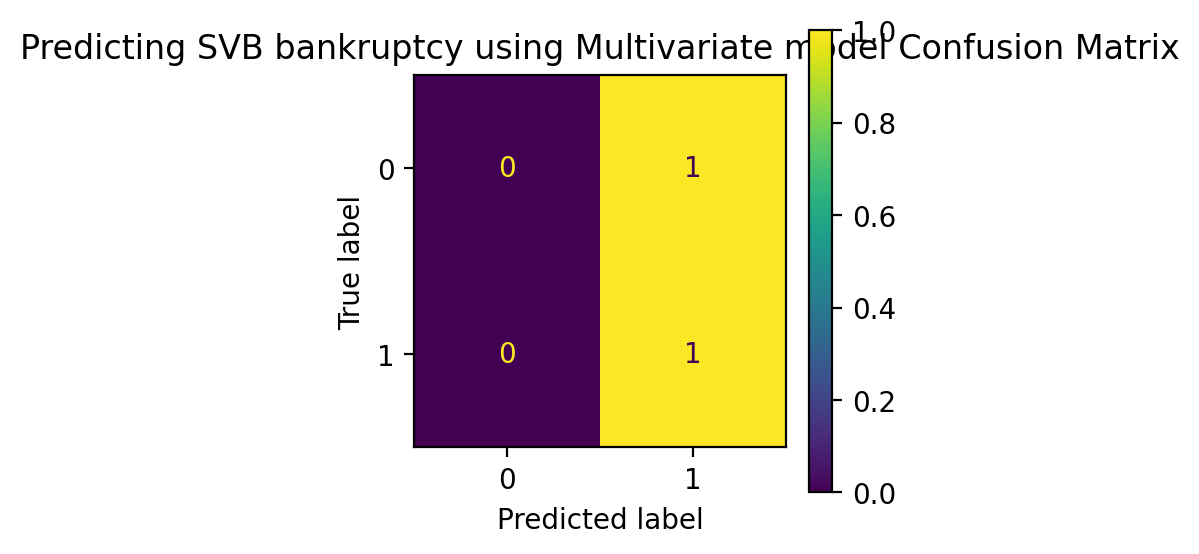

In [57]:
fig, ax = plt.subplots(figsize = (3, 3))

performance_with_threshold(Multi_logistic_model, X_SVB, X_train, y_SVB, y_train, multi_thresh, "Predicting SVB bankruptcy using Multivariate model", ax)

              precision    recall  f1-score   support

 No bankrupt       0.00      0.00      0.00         1
    Bankrupt       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

The accuracy score for the testing data of Predicting SVB bankruptcy using Debt model is 1.0  and training data is 0.8147152285504766


C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


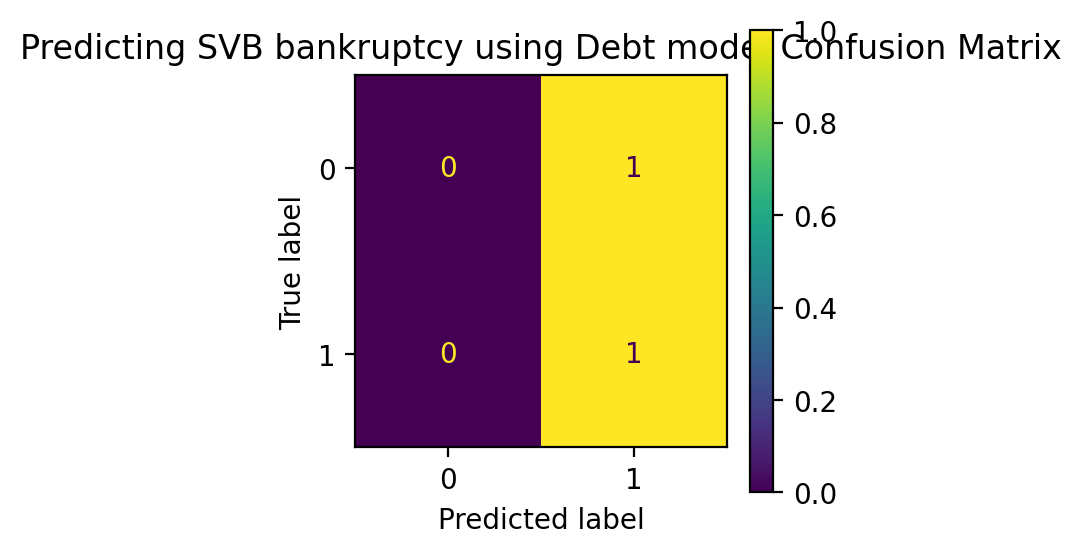

In [58]:
X_SVB_debt = X_SVB[[' Debt ratio %']]
fig, ax = plt.subplots(figsize = (3, 3))

performance_with_threshold(logistic_model_debt, X_SVB_debt, X_train_debt, y_SVB, y_train, debt_thresh, "Predicting SVB bankruptcy using Debt model", ax)

              precision    recall  f1-score   support

 No bankrupt       0.00      0.00      0.00         1
    Bankrupt       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

The accuracy score for the testing data of Predicting SVB bankruptcy using assets model is 0.0  and training data is 0.8147152285504766


C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


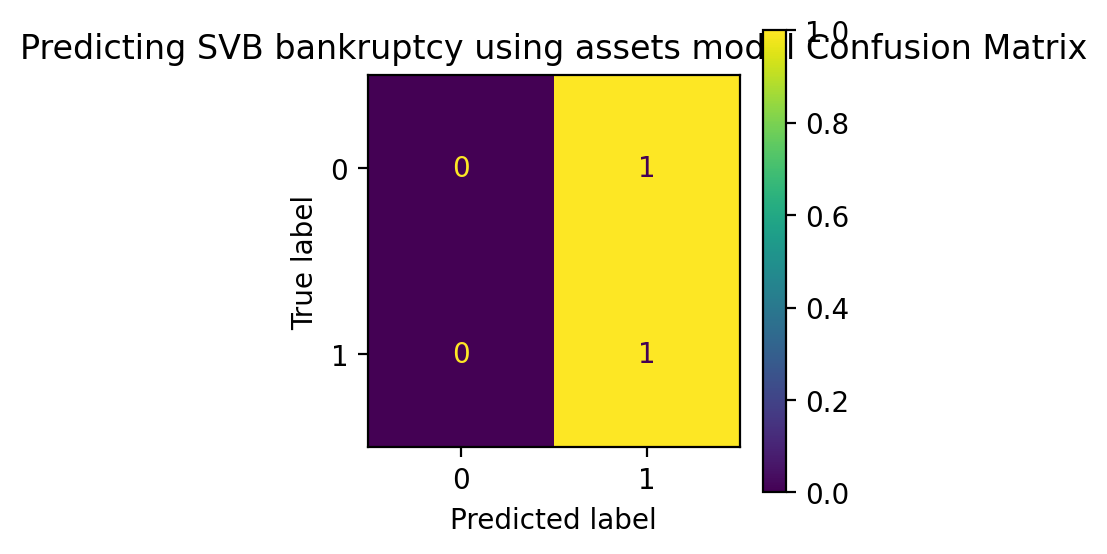

In [59]:
X_SVB_assets = X_SVB[[' Net worth/Assets']]
fig, ax = plt.subplots(figsize = (3, 3))

performance_with_threshold(logistic_model_assets, X_SVB_assets, X_train_assets, y_SVB, y_train, assets_thresh, "Predicting SVB bankruptcy using assets model", ax)

              precision    recall  f1-score   support

 No bankrupt       0.00      0.00      0.00         1
    Bankrupt       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

The accuracy score for the testing data of Predicting SVB bankruptcy using equity model is 0.0  and training data is 0.7499388902468834


C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rosly\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


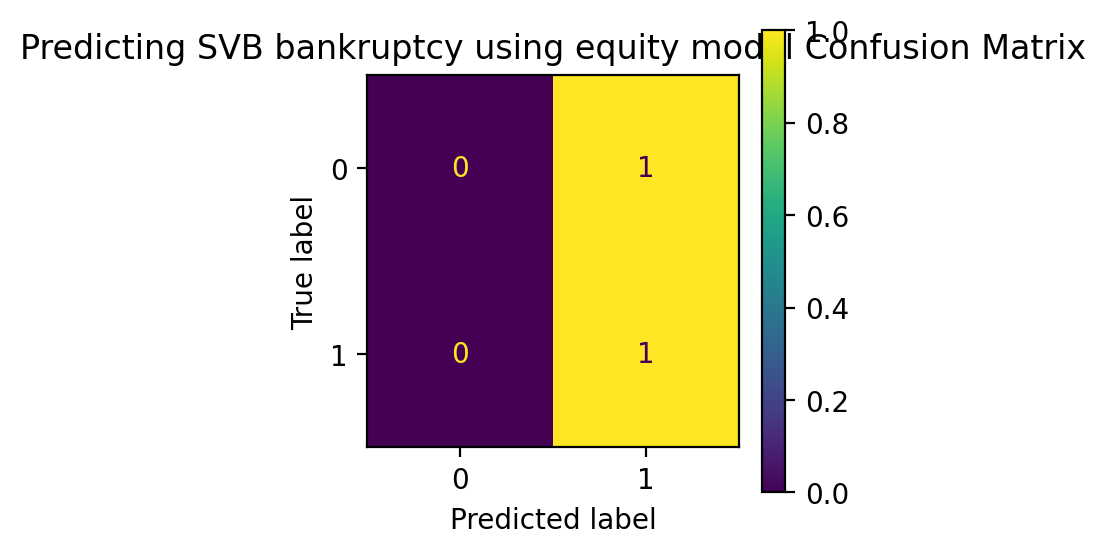

In [60]:
X_SVB_equity = X_SVB[[" Net Income to Stockholder's Equity"]]
fig, ax = plt.subplots(figsize = (3, 3))

performance_with_threshold(logistic_model_equity, X_SVB_equity, X_train_equity, y_SVB, y_train, equity_thresh, "Predicting SVB bankruptcy using equity model", ax)

In the end we were unable to predict the bankruptcies accurately even with the threshold. While the model used to model net income and shareholder equity did not return any bankruptcies, all other models predicted two bankruptcies even where it should not have. Given that even with the data that the models were trained on the accuracy was modest, it is no surprise that it would not be able to model bankruptcy for the Silicon Valley Bank data. 

### Conclusion and Limitations

Overall, 
- From exploratory analysis, we see relationships corresponding with our expectations: The higher the debt, the higher the bankruptcy probability; the worsening operations or lower equity, the higher the bankruptcy probability.


- From the logistic regressions, we see underfitting in models. While we try to battle the tradeoff between precision and recall, we see improvements in accuracy when setting the optimal thresholds. Compared with univariate regressions, the multivariate regression does not appear to be able to predict bankruptcy without the other variables.


- In the end, we fit the SVB data to the models. We see some accuracies in the multivariate and debt ratio models in forecasting bankruptcy.


#### Potential Limitations: 
- The model could be much better if U.S. firms' data were available.
- The models are underfitting as bankruptcy is a multi-factor complex thing: implication to consider either using a more robust model or adding additional features.
- We were ignoring economic-wide factors such as the pandemic, war, and recession that could lead to default.

### References & Sources of Datasets:
- Company Bankruptcy Prediction, Bankruptcy data from the Taiwan Economic Journal for the years 1999–2009, https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

- SVB Annual Report https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fd18rn0p25nwr6d.cloudfront.net%2FCIK-0000719739%2F6f63adbb-94c2-4db9-a401-459ea3934a21.xls&wdOrigin=BROWSELINK

- https://ir.svb.com/financials/annual-reports-and-proxies/default.aspx

- https://en.wikipedia.org/wiki/Economy_of_Taiwan
- https://www.heritage.org/index/country/taiwan#:~:text=Taiwan's%20economy%20is%20rated%20%E2%80%9Cfree,global%20leader%20in%20economic%20freedom.
- https://www.investopedia.com/terms/d/default2.asp
- https://twse-regulation.twse.com.tw/ENG/EN/law/DAT0201.aspx?FLCODE=FL020553